In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics


## Lectura y limpieza de datos
- lectura del .csv
- vista de los tipos de datos en DF original
- Creacion del df_todos que es identico al original, pero solo con las 4 columnas importantes

DF hasta noviembre (entrenamiento)
DF del mes de noviembre (testeo)
- Luego se crean otros 2 DF partiendo de las 2 anteriores:
  -  con las sumatorias de las ventas por dia



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd.set_option('display.float_format', '{:.4f}'.format)


In [4]:
# si se importa desde Drive
file_path = '/content/drive/MyDrive/DIPLOMADO/Proy_Final/datos/tabla_13_modif_top10ventas_nov_v2.csv'
# si se importa subiendo el archivo
# file_name = "tabla_11_modif_top10ventas_nov.csv"
df = pd.read_csv(file_path)
df.head()

CodigoSucursal  CodigoDepartamento CodigoEstado TipoMovimiento  \
0              13                   1           AC            SVE   
1              13                   1           AC            SVE   
2              13                   1           AC            SVE   
3              13                   1           AC            SVE   
4              13                   1           AC            SVE   

  DescripcionMovimiento  NumeroMovimiento  NumeroCorrelativo FechaMovimiento  \
0   VENTA COMPUTARIZADA          18112056                  0      2018-11-15   
1   VENTA COMPUTARIZADA          18112055                  0      2018-11-15   
2   VENTA COMPUTARIZADA          18112052                  0      2018-11-15   
3   VENTA COMPUTARIZADA          18112050                  0      2018-11-15   
4   VENTA COMPUTARIZADA          18112049                  0      2018-11-15   

    NombreProducto UnidadMedida  CantidadSalida  PesoSalida  MontoBase  \
0           CUELLO           KG          0.0000      0.6532     2.5760   
1  FILETE A GRANEL           KG          0.0000      1.9826    47.0120   
2  FILETE A GRANEL           KG          0.0000      1.9246    45.6320   
3  FILETE A GRANEL           KG          0.0000      0.8418    19.9640   
4           PIERNA           KG          0.0000      0.1334     2.1160   

   PrecioUnitario  CostoUnitario  MontoReferencia NombreGrupo  
0          3.5880         3.5880           0.3698     TROZADO  
1         21.8040        21.8040           6.7546     TROZADO  
2         21.8040        21.8040           6.5559     TROZADO  
3         21.8040        21.8040           2.8686     TROZADO  
4         14.7200        14.7200           0.3036     TROZADO

In [5]:
df['FechaMovimiento'] = pd.to_datetime(df['FechaMovimiento'])
df['year'] = df['FechaMovimiento'].dt.year
df.dtypes

CodigoSucursal                    int64
CodigoDepartamento                int64
CodigoEstado                     object
TipoMovimiento                   object
DescripcionMovimiento            object
NumeroMovimiento                  int64
NumeroCorrelativo                 int64
FechaMovimiento          datetime64[ns]
NombreProducto                   object
UnidadMedida                     object
CantidadSalida                  float64
PesoSalida                      float64
MontoBase                       float64
PrecioUnitario                  float64
CostoUnitario                   float64
MontoReferencia                 float64
NombreGrupo                      object
year                              int64
dtype: object

In [6]:
df_todo = df[['NombreProducto',
              'FechaMovimiento',
              'MontoBase',
              'year'
              ]]

In [7]:
#df_todo = df_todo.rename(columns={'FechaMovimiento': 'ds', 'MontoBase': 'y'})
df_todo.sort_values(by='FechaMovimiento', inplace=True)

<ipython-input-7-3f20b1242116>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_todo.sort_values(by='FechaMovimiento', inplace=True)


In [8]:
# Filtrar los registros de noviembre 2023
df_noviembre = df_todo[(df_todo['FechaMovimiento'] >= '2023-11-01') & (df_todo['FechaMovimiento'] < '2023-12-01')]

# Restar los registros de noviembre del conjunto original
df_todo_hasta_nov = df_todo[(df_todo['FechaMovimiento'] >= '2021-01-01') & (df_todo['FechaMovimiento'] < '2023-11-01')]

df_todo = df_todo[df_todo['FechaMovimiento'] < '2023-12-01']

In [9]:
print("todo                       - ", df_todo.shape)
print("desde 2021 hasta nov2023   - ", df_todo_hasta_nov.shape)
print("noviembre 2023             - ", df_noviembre.shape)

todo                       -  (195761, 4)
desde 2021 hasta nov2023   -  (122417, 4)
noviembre 2023             -  (2486, 4)


In [10]:
# df_noviembre.head()
df_todo_hasta_nov

NombreProducto FechaMovimiento  MontoBase  year
147201                    HIGADO      2021-01-02     3.8270  2021
147206  POLLO SIN MENUDENCIA H-C      2021-01-02    27.8570  2021
147205  POLLO SIN MENUDENCIA H-C      2021-01-02    55.8030  2021
147204  POLLO SIN MENUDENCIA H-C      2021-01-02    30.6160  2021
147203  POLLO SIN MENUDENCIA H-C      2021-01-02   105.4650  2021
...                          ...             ...        ...   ...
195933  POLLO SIN MENUDENCIA H-C      2023-10-31    28.5957  2023
195932            POLLO ESPECIAL      2023-10-31    26.5576  2023
195931  POLLO SIN MENUDENCIA H-C      2023-10-31    30.1621  2023
195930  POLLO SIN MENUDENCIA H-C      2023-10-31    27.5188  2023
195929  POLLO SIN MENUDENCIA H-C      2023-10-31   110.1820  2023

[122417 rows x 4 columns]

## EVALUACION

In [11]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        # Filtrar valores donde y_true es distinto de 0
        non_zero_indices = np.where(y_true != 0)
        y_true, y_pred = np.array(y_true)[non_zero_indices], np.array(y_pred)[non_zero_indices]

        if len(y_true) == 0:
            # Si no hay valores válidos, retornar un valor especial (por ejemplo, np.nan)
            return np.nan

        # Calcular MAPE solo para los valores válidos
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Contar valores reales y omitidos
    total_dias = len(y_true)
    dias_reales = np.sum(y_true != 0)
    dias_omitidos = total_dias - dias_reales

    print('Evaluation metric results:  ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
    print("---" * 10)
    print(f'Días reales calculados: {dias_reales}')
    print(f'Días omitidos: {dias_omitidos}')
    print(f'Total de días: {total_dias}')
    print("---" * 10)
    print("\n")

In [12]:
def evaluacion_metrica_todos_los_valores(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)} %',end='\n')
    print("---"*10)
    print(f'MRSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)} %')
    print("---"*10)
print("\n\n")

# Creacion del objeto con los dataframes de los 3 productos


In [13]:
## Tratamos la columna 'FechaMovimiento' de ambos dataframes
# Primero cambiamos la columna ds a datatime
df_noviembre['FechaMovimiento'] = pd.to_datetime(df_noviembre['FechaMovimiento'])
df_todo_hasta_nov['FechaMovimiento'] = pd.to_datetime(df_todo_hasta_nov['FechaMovimiento'])
# se quitan las horas de la columna de tiempo
df_noviembre['FechaMovimiento'] = df_noviembre['FechaMovimiento'].dt.date
df_todo_hasta_nov['FechaMovimiento'] = df_todo_hasta_nov['FechaMovimiento'].dt.date

print(df_noviembre.head)
print(df_noviembre.dtypes)
print(df_todo_hasta_nov.head)
print(df_todo_hasta_nov.dtypes)

<bound method NDFrame.head of                   NombreProducto FechaMovimiento  MontoBase  year
116355                   PECHUGA      2023-11-01    22.8344  2023
116354           FILETE A GRANEL      2023-11-01    30.1024  2023
116368                    PIERNA      2023-11-01    15.2352  2023
116351                     MUSLO      2023-11-01    21.2152  2023
116352              PIERNA MUSLO      2023-11-01    18.2068  2023
...                          ...             ...        ...   ...
194984            POLLO ESPECIAL      2023-11-30    29.5658  2023
194985            POLLO ESPECIAL      2023-11-30    25.5341  2023
194982            POLLO ESPECIAL      2023-11-30    78.6226  2023
194983  POLLO SIN MENUDENCIA H-C      2023-11-30    29.1386  2023
194981            POLLO ESPECIAL      2023-11-30    29.9663  2023

[2486 rows x 4 columns]>
NombreProducto      object
FechaMovimiento     object
MontoBase          float64
year                 int64
dtype: object
<bound method NDFrame.head of 

### Seleccion de los productos top 3


In [14]:
# Obtener los nombres de los 10 productos más vendidos
top_10_productos = df_todo_hasta_nov.groupby('NombreProducto')['MontoBase'].sum().sort_values(ascending=False).head(10)

# Imprimir los nombres de los productos
print("Nombres de los 10 productos más vendidos:")
print(top_10_productos.index)

# Obtener los días de venta para cada producto
dias_de_venta_por_producto = df_todo_hasta_nov.groupby(['NombreProducto', 'FechaMovimiento'])['MontoBase'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.groupby('NombreProducto')['FechaMovimiento'].count().reset_index()
dias_de_venta_por_producto = dias_de_venta_por_producto.rename(columns={'FechaMovimiento': 'DiasDeVenta'})
dias_de_venta_por_producto = dias_de_venta_por_producto.sort_values(by='DiasDeVenta', ascending=False).reset_index(drop=True)

# Imprimir los días de venta para cada producto
print("\nDías de venta para cada producto:")
print(dias_de_venta_por_producto)

# Paso 3: Seleccionar los nombres de los tres primeros productos
nombres_productos_con_mas_ventas = dias_de_venta_por_producto['NombreProducto'].head(10).tolist()

# Filtrar y ordenar los productos por la suma total de MontoBase
ventas_por_producto = df.groupby('NombreProducto')['MontoBase'].sum().reset_index()
top_productos = ventas_por_producto[ventas_por_producto['NombreProducto'].isin(nombres_productos_con_mas_ventas)]
top_productos = top_productos.sort_values(by='MontoBase', ascending=False).reset_index(drop=True)

top_productos = pd.merge(top_productos, dias_de_venta_por_producto, on='NombreProducto')

# Imprimir los días de venta y el MontoBase total de cada producto
print("\nDías de venta y MontoBase total para cada producto:")
print(top_productos[['NombreProducto', 'MontoBase']])

# Seleccionar el top 3 productos en función de la suma total de MontoBase
top_3_productos = top_productos.head(3)

print("\n Posible Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

# Verificar si hay algún producto en el top 3 con menos de 750 días de venta
if top_3_productos['DiasDeVenta'].min() < 750:
    # Obtener el índice del producto con menos de 750 días de venta
    indice_producto = top_3_productos[top_3_productos['DiasDeVenta'] < 750].index[0]

    # Obtener el siguiente producto con más de 750 días de venta
    siguiente_producto = top_productos[top_productos['DiasDeVenta'] >= 750].iloc[indice_producto]

    # Reemplazar el producto en el top 3 con el siguiente producto
    top_3_productos.iloc[-1] = siguiente_producto

# Formatear la columna 'MontoBase' con 2 decimales
top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))

# Imprimir la lista final
print("\n Lista Final")
print(top_3_productos[['NombreProducto', 'DiasDeVenta', 'MontoBase']])

Nombres de los 10 productos más vendidos:
Index(['POLLO ESPECIAL', 'POLLO SIN MENUDENCIA H-C', 'PIERNA MUSLO', 'PECHUGA',
       'FILETE A GRANEL', 'PIERNA', 'MUSLO', 'ALA PRIMERA', 'CUELLO',
       'HIGADO'],
      dtype='object', name='NombreProducto')

Días de venta para cada producto:
             NombreProducto  DiasDeVenta
0            POLLO ESPECIAL          998
1  POLLO SIN MENUDENCIA H-C          976
2                    PIERNA          960
3                   PECHUGA          955
4              PIERNA MUSLO          945
5           FILETE A GRANEL          895
6                     MUSLO          883
7                    CUELLO          763
8               ALA PRIMERA          709
9                    HIGADO          687

Días de venta y MontoBase total para cada producto:
             NombreProducto    MontoBase
0            POLLO ESPECIAL 2858247.6380
1  POLLO SIN MENUDENCIA H-C 1731306.6315
2              PIERNA MUSLO  899721.8384
3                   PECHUGA  824782.3092
4

<ipython-input-14-bd44a9b6d38c>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_productos['MontoBase'] = top_3_productos['MontoBase'].apply(lambda x: '{:.2f}'.format(x))


### Creacion de objetos que contienen 10 DF c/u con los productos mas vendidos

In [15]:
#objeto que contendra los dataframes de los top 3 productos
dfs_de_productos = {}

# Iterar sobre los productos y dividir el DataFrame
for nombre_producto in top_3_productos['NombreProducto']:
    # Crear un DataFrame para el producto actual
    product_df = df_todo_hasta_nov[df_todo_hasta_nov['NombreProducto'] == nombre_producto].copy()

    # Opcional: Puedes establecer la columna de fecha como índice si es relevante para tus análisis
    product_df.set_index('FechaMovimiento', inplace=True)

    # Almacenar el DataFrame en el diccionario
    dfs_de_productos[nombre_producto] = product_df

In [16]:
# dfs_de_productos

In [17]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_de_productos_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_productos.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_de_productos_sumados[product] = product_df_sumado

In [18]:
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].tail)
# print(dfs_de_productos_sumados['PIERNA MUSLO'].tail)
# print(dfs_de_productos['POLLO SIN MENUDENCIA H-C'].head)

FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
<bound method NDFrame.tail of     FechaMovimiento            NombreProducto  year  MontoBase
0        2021-01-02  POLLO SIN MENUDENCIA H-C  2021   818.4440
1        2021-01-03  POLLO SIN MENUDENCIA H-C  2021   633.5910
2        2021-01-04  POLLO SIN MENUDENCIA H-C  2021   904.3290
3        2021-01-05  POLLO SIN MENUDENCIA H-C  2021   903.1720
4        2021-01-06  POLLO SIN MENUDENCIA H-C  2021   571.2910
..              ...                       ...   ...        ...
971      2023-10-27  POLLO SIN MENUDENCIA H-C  2023   816.5305
972      2023-10-28  POLLO SIN MENUDENCIA H-C  2023   927.1219
973      2023-10-29  POLLO SIN MENUDENCIA H-C  2023  1241.6123
974      2023-10-30  POLLO SIN MENUDENCIA H-C  2023   652.0852
975      2023-10-31  POLLO SIN MENUDENCIA H-C  2023   654.0076

[976 rows x 4 columns]>


In [19]:
# Iterar sobre los productos
for product, product_df in dfs_de_productos_sumados.items():
    # Obtener la última fecha en la columna 'FechaMovimiento'
    last_date = product_df['FechaMovimiento'].max()

    # Verificar si la última fecha es diferente al último día de octubre de 2023
    last_day_oct_2023 = pd.to_datetime('2023-10-31')

    if last_date != last_day_oct_2023:
        # Agregar un nuevo registro con venta 0
        new_row = pd.DataFrame([[product, 2023, 0, last_day_oct_2023]], columns=['NombreProducto', 'year', 'MontoBase', 'FechaMovimiento'])

        # Concatenar el nuevo registro al DataFrame existente
        product_df = pd.concat([product_df, new_row])

        # Ordenar el DataFrame por la fecha
        product_df.sort_values(by=['year', 'NombreProducto', 'FechaMovimiento'], inplace=True)

        # Imprimir información sobre el producto
        print(f"Se agregó un registro de venta 0 para el producto {product} en la fecha {last_day_oct_2023}")

    # Establecer 'FechaMovimiento' como índice después de agregar los registros de venta '0'
    product_df.set_index('FechaMovimiento', inplace=True)
    # Actualizar el DataFrame en el diccionario
    dfs_de_productos_sumados[product] = product_df
    # Resetear el índice antes de clonar
    #product_df.reset_index(inplace=True)

<ipython-input-19-7c618e69a328>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-19-7c618e69a328>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:
<ipython-input-19-7c618e69a328>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if last_date != last_day_oct_2023:


In [20]:
print(dfs_de_productos_sumados)

{'POLLO ESPECIAL':                  NombreProducto  year  MontoBase
FechaMovimiento                                 
2021-01-02       POLLO ESPECIAL  2021  1822.6310
2021-01-03       POLLO ESPECIAL  2021   543.4340
2021-01-04       POLLO ESPECIAL  2021  1221.7920
2021-01-05       POLLO ESPECIAL  2021  1963.7850
2021-01-06       POLLO ESPECIAL  2021  1012.1080
...                         ...   ...        ...
2023-10-27       POLLO ESPECIAL  2023  2152.1624
2023-10-28       POLLO ESPECIAL  2023  2499.2891
2023-10-29       POLLO ESPECIAL  2023  1611.2471
2023-10-30       POLLO ESPECIAL  2023  3372.2990
2023-10-31       POLLO ESPECIAL  2023  2112.0323

[998 rows x 3 columns], 'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2021-01-02       POLLO SIN MENUDENCIA H-C  2021   818.4440
2021-01-03       POLLO SIN MENUDENCIA H-C  2021   633.5910
2021-01-04       POLLO SIN MENUDENCIA H-C  2021   904.3

In [21]:
import copy

# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_prophet = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_prophet in dfs_de_productos_sumados_prophet.items():
    # Cambiar el nombre de las columnas
    product_df_prophet.rename(columns={'MontoBase': 'y'}, inplace=True)

    # Restablecer el índice
    product_df_prophet.reset_index(inplace=True)

    # Cambiar el nombre de la columna 'FechaMovimiento' a 'ds'
    product_df_prophet.rename(columns={'index': 'ds'}, inplace=True)
    product_df_prophet.rename(columns={'FechaMovimiento': 'ds'}, inplace=True)

    # Eliminar la columna 'year'
    product_df_prophet.drop(columns=['year'], inplace=True)

In [22]:
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados['POLLO SIN MENUDENCIA H-C'].head)

NombreProducto     object
year                int64
MontoBase         float64
dtype: object
<bound method NDFrame.head of                            NombreProducto  year  MontoBase
FechaMovimiento                                           
2021-01-02       POLLO SIN MENUDENCIA H-C  2021   818.4440
2021-01-03       POLLO SIN MENUDENCIA H-C  2021   633.5910
2021-01-04       POLLO SIN MENUDENCIA H-C  2021   904.3290
2021-01-05       POLLO SIN MENUDENCIA H-C  2021   903.1720
2021-01-06       POLLO SIN MENUDENCIA H-C  2021   571.2910
...                                   ...   ...        ...
2023-10-27       POLLO SIN MENUDENCIA H-C  2023   816.5305
2023-10-28       POLLO SIN MENUDENCIA H-C  2023   927.1219
2023-10-29       POLLO SIN MENUDENCIA H-C  2023  1241.6123
2023-10-30       POLLO SIN MENUDENCIA H-C  2023   652.0852
2023-10-31       POLLO SIN MENUDENCIA H-C  2023   654.0076

[976 rows x 3 columns]>


In [23]:
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_prophet['POLLO SIN MENUDENCIA H-C'].head)

ds                 object
NombreProducto     object
y                 float64
dtype: object
<bound method NDFrame.head of              ds            NombreProducto         y
0    2021-01-02  POLLO SIN MENUDENCIA H-C  818.4440
1    2021-01-03  POLLO SIN MENUDENCIA H-C  633.5910
2    2021-01-04  POLLO SIN MENUDENCIA H-C  904.3290
3    2021-01-05  POLLO SIN MENUDENCIA H-C  903.1720
4    2021-01-06  POLLO SIN MENUDENCIA H-C  571.2910
..          ...                       ...       ...
971  2023-10-27  POLLO SIN MENUDENCIA H-C  816.5305
972  2023-10-28  POLLO SIN MENUDENCIA H-C  927.1219
973  2023-10-29  POLLO SIN MENUDENCIA H-C 1241.6123
974  2023-10-30  POLLO SIN MENUDENCIA H-C  652.0852
975  2023-10-31  POLLO SIN MENUDENCIA H-C  654.0076

[976 rows x 3 columns]>


In [24]:
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)

             ds  NombreProducto         y
0    2021-01-02  POLLO ESPECIAL 1822.6310
1    2021-01-03  POLLO ESPECIAL  543.4340
2    2021-01-04  POLLO ESPECIAL 1221.7920
3    2021-01-05  POLLO ESPECIAL 1963.7850
4    2021-01-06  POLLO ESPECIAL 1012.1080
..          ...             ...       ...
993  2023-10-27  POLLO ESPECIAL 2152.1624
994  2023-10-28  POLLO ESPECIAL 2499.2891
995  2023-10-29  POLLO ESPECIAL 1611.2471
996  2023-10-30  POLLO ESPECIAL 3372.2990
997  2023-10-31  POLLO ESPECIAL 2112.0323

[998 rows x 3 columns]
             ds            NombreProducto         y
0    2021-01-02  POLLO SIN MENUDENCIA H-C  818.4440
1    2021-01-03  POLLO SIN MENUDENCIA H-C  633.5910
2    2021-01-04  POLLO SIN MENUDENCIA H-C  904.3290
3    2021-01-05  POLLO SIN MENUDENCIA H-C  903.1720
4    2021-01-06  POLLO SIN MENUDENCIA H-C  571.2910
..          ...                       ...       ...
971  2023-10-27  POLLO SIN MENUDENCIA H-C  816.5305
972  2023-10-28  POLLO SIN MENUDENCIA H-C  927.1219
973 

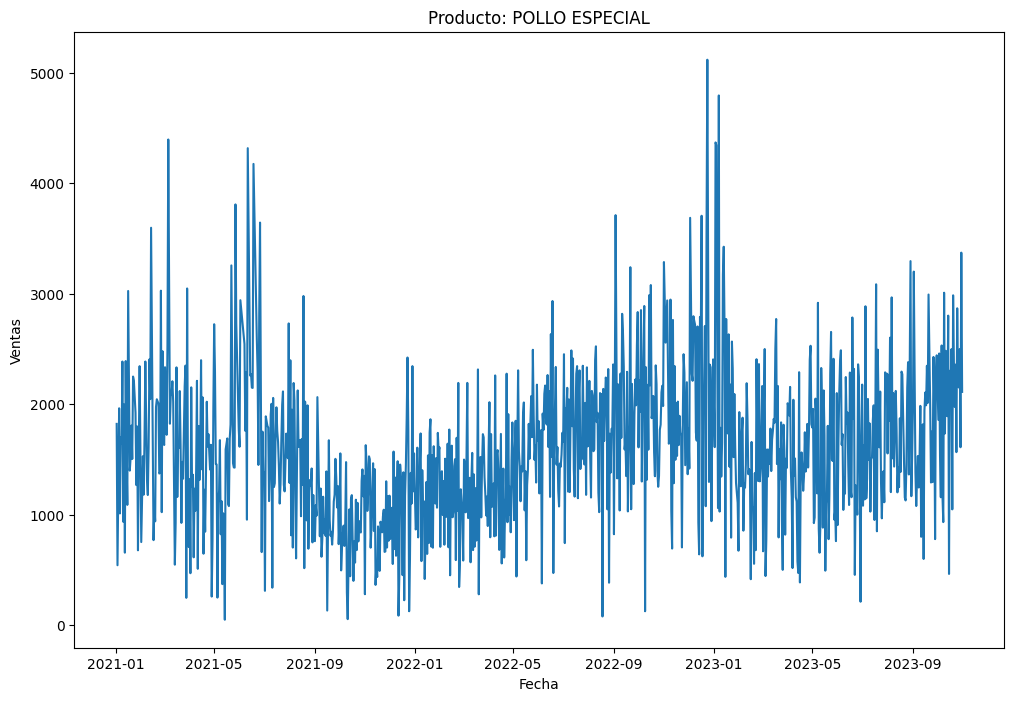

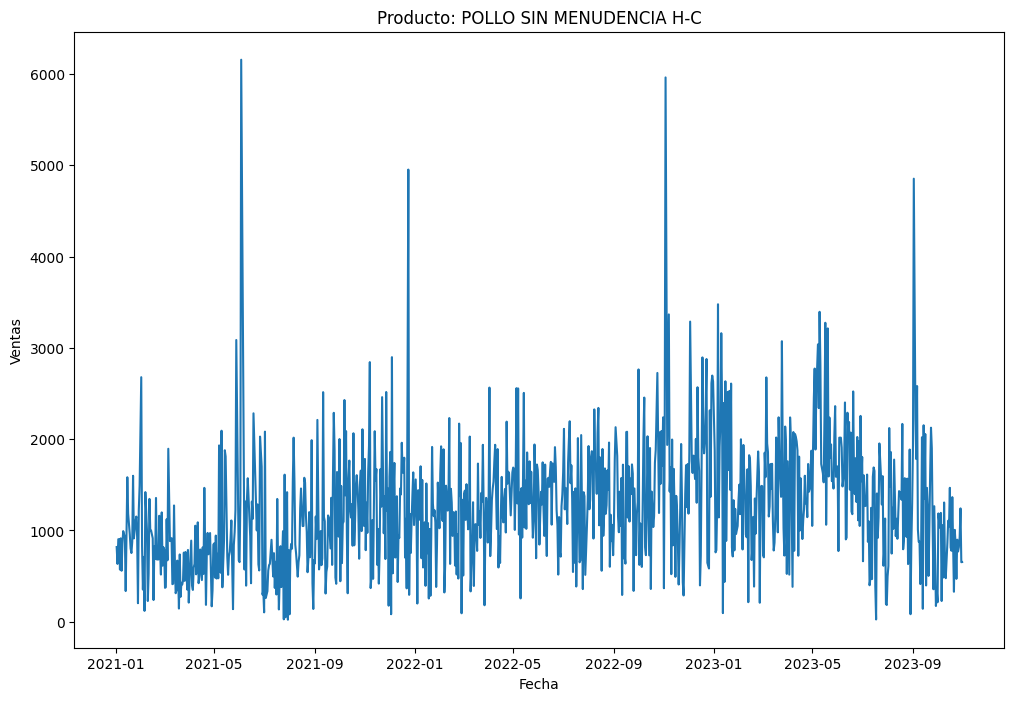

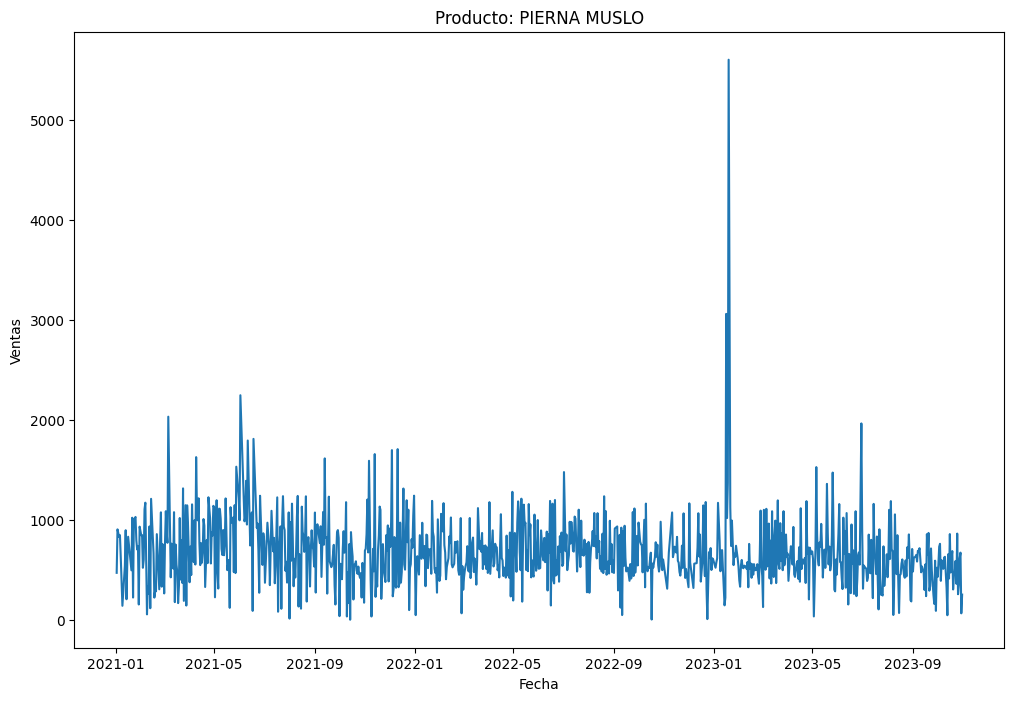

In [25]:
# Iterar sobre los productos y sus DataFrames
for i, (product, product_df) in enumerate(dfs_de_productos_sumados_prophet.items()):
    # Crear una nueva figura y ejes para cada producto
    fig, ax = plt.subplots(figsize=(12, 8))

    # Crear un gráfico de líneas para cada producto
    ax.plot(product_df['ds'], product_df['y'], label=product)
    ax.set_title(f'Producto: {product}')  # Utiliza 'set_title' en lugar de 'plt.set_title'
    ax.set_xlabel('Fecha')  # Utiliza 'set_xlabel' en lugar de 'plt.set_xlabel'
    ax.set_ylabel('Ventas')  # Utiliza 'set_ylabel' en lugar de 'plt.set_ylabel'

    # Mostrar el gráfico para el producto actual
    plt.show()

In [26]:
for i, df_product in enumerate(dfs_de_productos_sumados):
    print(f"DataFrame {i + 1} - Tipos de Datos:")
    print(dfs_de_productos_sumados[df_product].dtypes)
    print("=" * 30)

DataFrame 1 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 2 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
DataFrame 3 - Tipos de Datos:
NombreProducto     object
year                int64
MontoBase         float64
dtype: object


### clonar para LSTM y ARIMA


In [27]:
dfs_de_productos_sumados

{'POLLO ESPECIAL':                  NombreProducto  year  MontoBase
 FechaMovimiento                                 
 2021-01-02       POLLO ESPECIAL  2021  1822.6310
 2021-01-03       POLLO ESPECIAL  2021   543.4340
 2021-01-04       POLLO ESPECIAL  2021  1221.7920
 2021-01-05       POLLO ESPECIAL  2021  1963.7850
 2021-01-06       POLLO ESPECIAL  2021  1012.1080
 ...                         ...   ...        ...
 2023-10-27       POLLO ESPECIAL  2023  2152.1624
 2023-10-28       POLLO ESPECIAL  2023  2499.2891
 2023-10-29       POLLO ESPECIAL  2023  1611.2471
 2023-10-30       POLLO ESPECIAL  2023  3372.2990
 2023-10-31       POLLO ESPECIAL  2023  2112.0323
 
 [998 rows x 3 columns],
 'POLLO SIN MENUDENCIA H-C':                            NombreProducto  year  MontoBase
 FechaMovimiento                                           
 2021-01-02       POLLO SIN MENUDENCIA H-C  2021   818.4440
 2021-01-03       POLLO SIN MENUDENCIA H-C  2021   633.5910
 2021-01-04       POLLO SIN MENUDENCI

In [28]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_lstm = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():
    # Restablecer el índice
    product_df_lstm.reset_index(inplace=True)
    print(product_df_lstm.head)
    print(product_df_lstm.dtypes)

    # Convertir 'FechaMovimiento' a tipo de dato datetime
    product_df_lstm['FechaMovimiento'] = pd.to_datetime(product_df_lstm['FechaMovimiento'])

    # Configurar 'FechaMovimiento' como índice
    product_df_lstm.set_index('FechaMovimiento', inplace=True)
    print(product_df_lstm.dtypes)

    # Preprocesamiento de fechas utilizando el índice
    product_df_lstm['DayOW'] = product_df_lstm.index.dayofweek
    product_df_lstm['Month'] = product_df_lstm.index.month
    product_df_lstm['Year'] = product_df_lstm.index.year

    product_df_lstm.drop(columns=['year'], inplace=True)

    # Ordenar el DataFrame por la fecha (si es necesario)
    product_df_lstm.sort_index(inplace=True)

<bound method NDFrame.head of     FechaMovimiento  NombreProducto  year  MontoBase
0        2021-01-02  POLLO ESPECIAL  2021  1822.6310
1        2021-01-03  POLLO ESPECIAL  2021   543.4340
2        2021-01-04  POLLO ESPECIAL  2021  1221.7920
3        2021-01-05  POLLO ESPECIAL  2021  1963.7850
4        2021-01-06  POLLO ESPECIAL  2021  1012.1080
..              ...             ...   ...        ...
993      2023-10-27  POLLO ESPECIAL  2023  2152.1624
994      2023-10-28  POLLO ESPECIAL  2023  2499.2891
995      2023-10-29  POLLO ESPECIAL  2023  1611.2471
996      2023-10-30  POLLO ESPECIAL  2023  3372.2990
997      2023-10-31  POLLO ESPECIAL  2023  2112.0323

[998 rows x 4 columns]>
FechaMovimiento     object
NombreProducto      object
year                 int64
MontoBase          float64
dtype: object
NombreProducto     object
year                int64
MontoBase         float64
dtype: object
<bound method NDFrame.head of     FechaMovimiento            NombreProducto  year  MontoBase
0 

In [29]:
# Clonar completamente el objeto contenedor de DataFrames sumados
dfs_de_productos_sumados_arima = copy.deepcopy(dfs_de_productos_sumados)

# Iterar sobre los DataFrames en el nuevo objeto
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
     # Restablecer el índice
    product_df_arima.reset_index(inplace=True)

    # Configurar 'FechaMovimiento' como índice
    product_df_arima.set_index('FechaMovimiento', inplace=True)

    # Ordenar el DataFrame por la fecha
    product_df_arima.sort_index(inplace=True)
    # Eliminar la columna 'year'
    product_df_arima.drop(columns=['year'], inplace=True)

In [30]:
print(dfs_de_productos_sumados_arima['PIERNA MUSLO'])

                NombreProducto  MontoBase
FechaMovimiento                          
2021-01-02        PIERNA MUSLO   473.7080
2021-01-03        PIERNA MUSLO   907.9480
2021-01-05        PIERNA MUSLO   831.2200
2021-01-06        PIERNA MUSLO   850.4480
2021-01-07        PIERNA MUSLO   626.8880
...                        ...        ...
2023-10-27        PIERNA MUSLO   353.7400
2023-10-28        PIERNA MUSLO   618.4240
2023-10-29        PIERNA MUSLO   675.5468
2023-10-30        PIERNA MUSLO    69.0736
2023-10-31        PIERNA MUSLO   256.0544

[945 rows x 2 columns]


## Noviembre
Antes de empezar con los modelos se debe Almacenar los valores de venta REALES de Noviembre de 2023 para comparar las predicciones de cada Modelo

In [31]:
# Crear un diccionario para almacenar los DataFrames divididos
dfs_de_Noviembre = {}

# Iterar sobre los productos y dividir el DataFrame
for product in top_3_productos['NombreProducto']:
    product_nov = df_noviembre[df_noviembre['NombreProducto'] == product].copy()

    product_nov.set_index('FechaMovimiento', inplace=True)


    # Almacenar el DataFrame en el diccionario
    dfs_de_Noviembre[product] = product_nov

In [32]:
# Crear un diccionario para almacenar los DataFrames sumados
dfs_noviembre_sumados = {}

# Iterar sobre los productos en el diccionario original
for product, product_df in dfs_de_Noviembre.items():
    # Sumar las ventas por día sin perder 'NombreProducto' y 'year'
    product_df_sumado = product_df.groupby(['FechaMovimiento', 'NombreProducto', 'year'])['MontoBase'].sum().reset_index()

    # Establecer 'FechaMovimiento' como índice
    product_df_sumado.set_index('FechaMovimiento', inplace=True)

    product_df_sumado.drop(columns=['year'], inplace=True)

    # Agregar el DataFrame sumado al nuevo diccionario
    dfs_noviembre_sumados[product] = product_df_sumado

    product_df_sumado = product_df_sumado.rename_axis('FechaMovimiento')

print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase
FechaMovimiento                                     
2023-11-01       POLLO SIN MENUDENCIA H-C  1301.7229
2023-11-02       POLLO SIN MENUDENCIA H-C  1709.2895
2023-11-03       POLLO SIN MENUDENCIA H-C   707.2652
2023-11-04       POLLO SIN MENUDENCIA H-C  1296.7834
2023-11-05       POLLO SIN MENUDENCIA H-C   772.3420
2023-11-06       POLLO SIN MENUDENCIA H-C  2467.2758
2023-11-07       POLLO SIN MENUDENCIA H-C  1066.5938
2023-11-08       POLLO SIN MENUDENCIA H-C  1110.0792
2023-11-09       POLLO SIN MENUDENCIA H-C   259.3104
2023-11-11       POLLO SIN MENUDENCIA H-C   766.5036
2023-11-12       POLLO SIN MENUDENCIA H-C   916.6644
2023-11-13       POLLO SIN MENUDENCIA H-C   191.7683
2023-11-14       POLLO SIN MENUDENCIA H-C   955.1658
2023-11-15       POLLO SIN MENUDENCIA H-C   579.8350
2023-11-16       POLLO SIN MENUDENCIA H-C   943.6492
2023-11-17       POLLO SIN MENUDENCIA H-C   683.4933
2023-11-18       POLLO SIN MENUDENCIA H-C   77

In [33]:
# Definir el rango de fechas de noviembre
noviembre_range = pd.date_range(start='2023-11-01', end='2023-11-30')

# Iterar sobre los productos en dfs_noviembre_sumados
for product, product_df in dfs_noviembre_sumados.items():
    # Crear un DataFrame con el índice de noviembre
    noviembre_df = pd.DataFrame(index=noviembre_range)

    # Verificar si hay fechas en noviembre que no están en el DataFrame original
    missing_dates = noviembre_df.index.difference(product_df.index)

    print(f"Las fechas que no están en el producto {product} son: {missing_dates}")

    if not missing_dates.empty:
        # Agregar filas con ventas '0' para las fechas faltantes
        new_rows = pd.DataFrame({'NombreProducto': product, 'MontoBase': 0}, index=missing_dates)

        # Convertir el índice a formato de fecha
        new_rows.index = pd.to_datetime(new_rows.index).date

        product_df = pd.concat([product_df, new_rows])

        # Asignar nombre al índice
        product_df.index.name = 'FechaMovimiento'

        print(f"Se agregaron filas con ventas '0' para el producto {product} en las fechas faltantes.")

    # Ordenar el DataFrame por fecha
    product_df.sort_index(inplace=True)

    # Imprimir información sobre el producto
    print(f"Se agregaron {len(missing_dates)} registros de venta 0 para el producto {product} en noviembre.")

    # Actualizar el DataFrame en el diccionario
    dfs_noviembre_sumados[product] = product_df

print(dfs_noviembre_sumados)

Las fechas que no están en el producto POLLO ESPECIAL son: DatetimeIndex(['2023-11-17'], dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto POLLO ESPECIAL en las fechas faltantes.
Se agregaron 1 registros de venta 0 para el producto POLLO ESPECIAL en noviembre.
Las fechas que no están en el producto POLLO SIN MENUDENCIA H-C son: DatetimeIndex(['2023-11-10'], dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto POLLO SIN MENUDENCIA H-C en las fechas faltantes.
Se agregaron 1 registros de venta 0 para el producto POLLO SIN MENUDENCIA H-C en noviembre.
Las fechas que no están en el producto PIERNA MUSLO son: DatetimeIndex(['2023-11-23', '2023-11-24', '2023-11-25', '2023-11-27',
               '2023-11-28', '2023-11-29', '2023-11-30'],
              dtype='datetime64[ns]', freq=None)
Se agregaron filas con ventas '0' para el producto PIERNA MUSLO en las fechas faltantes.
Se agregaron 7 registros de venta 0 para el producto

In [34]:
# print(dfs_noviembre_sumados)

# PROPHET


## Predecir cada uno de los 10 productos mas vendidos

 Predicciones sin el 2020 de los 10 productos más vendidos

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds  NombreProducto         y
0    2021-01-02  POLLO ESPECIAL 1822.6310
1    2021-01-03  POLLO ESPECIAL  543.4340
2    2021-01-04  POLLO ESPECIAL 1221.7920
3    2021-01-05  POLLO ESPECIAL 1963.7850
4    2021-01-06  POLLO ESPECIAL 1012.1080
..          ...             ...       ...
993  2023-10-27  POLLO ESPECIAL 2152.1624
994  2023-10-28  POLLO ESPECIAL 2499.2891
995  2023-10-29  POLLO ESPECIAL 1611.2471
996  2023-10-30  POLLO ESPECIAL 3372.2990
997  2023-10-31  POLLO ESPECIAL 2112.0323

[998 rows x 3 columns]


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8pw8zoa9/7w6xxzrz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8pw8zoa9/j3z45qap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67116', 'data', 'file=/tmp/tmp8pw8zoa9/7w6xxzrz.json', 'init=/tmp/tmp8pw8zoa9/j3z45qap.json', 'output', 'file=/tmp/tmp8pw8zoa9/prophet_modelm31kqk01/prophet_model-20240302222106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:21:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


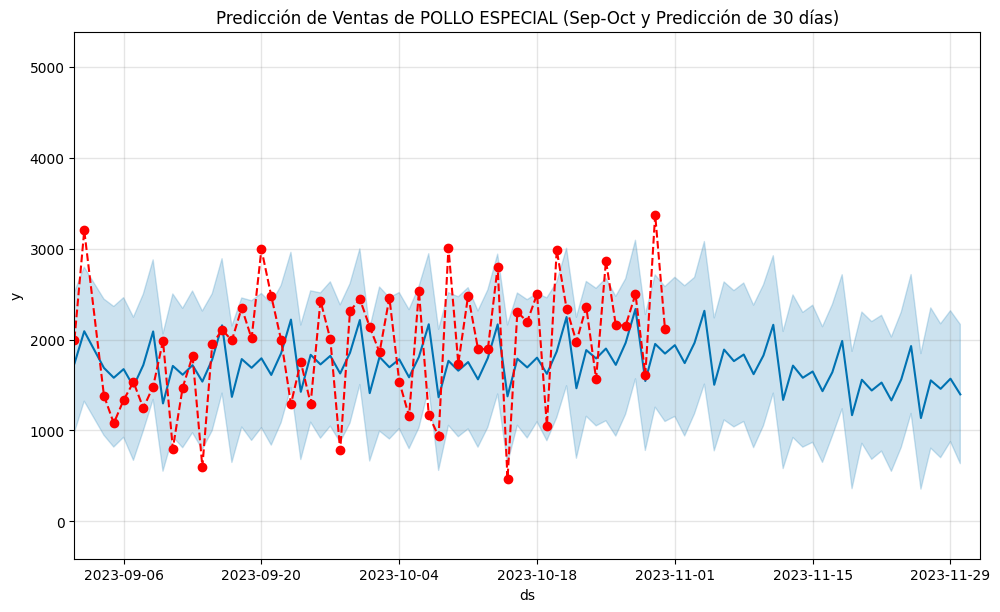

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8pw8zoa9/vjr3znte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8pw8zoa9/w5a158sh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49860', 'data', 'file=/tmp/tmp8pw8zoa9/vjr3znte.json', 'init=/tmp/tmp8pw8zoa9/w5a158sh.json', 'output', 'file=/tmp/tmp8pw8zoa9/prophet_model5qh61rve/prophet_model-20240302222107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para POLLO ESPECIAL:
             ds      yhat
998  2023-11-01 1938.0934
999  2023-11-02 1740.8432
1000 2023-11-03 1963.4582
1001 2023-11-04 2315.8646
1002 2023-11-05 1502.5276
1003 2023-11-06 1889.2897
1004 2023-11-07 1762.6734
1005 2023-11-08 1835.1293
1006 2023-11-09 1619.1114
1007 2023-11-10 1824.6313
1008 2023-11-11 2162.0183
1009 2023-11-12 1336.0989
1010 2023-11-13 1713.0265
1011 2023-11-14 1579.5766
1012 2023-11-15 1648.3889
1013 2023-11-16 1432.0375
1014 2023-11-17 1640.5829
1015 2023-11-18 1984.3302
1016 2023-11-19 1168.0099
1017 2023-11-20 1557.6097
1018 2023-11-21 1439.6735
1019 2023-11-22 1526.5497
1020 2023-11-23 1330.4680
1021 2023-11-24 1561.0997
1022 2023-11-25 1928.3252
1023 2023-11-26 1136.4251
1024 2023-11-27 1550.9220
1025 2023-11-28 1457.8907
1026 2023-11-29 1569.2170
1027 2023-11-30 1396.6848
             ds            NombreProducto         y
0    2021-01-02  POLLO SIN MENUDENCIA H-C  818.4440
1    2021-01-03  POLLO SIN MENUDENCI

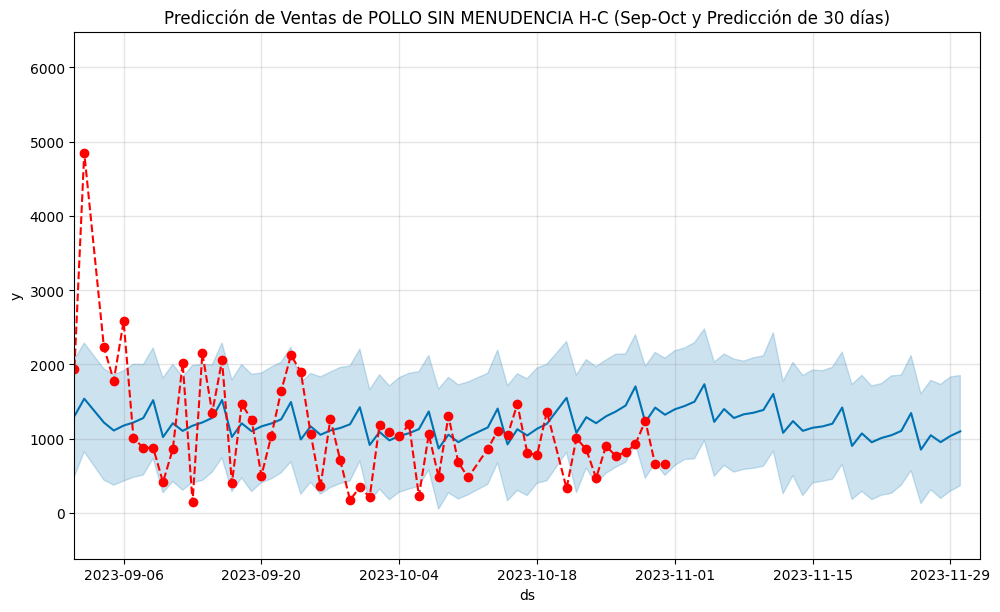

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8pw8zoa9/wgen2obo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8pw8zoa9/9ox0f6f2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72489', 'data', 'file=/tmp/tmp8pw8zoa9/wgen2obo.json', 'init=/tmp/tmp8pw8zoa9/9ox0f6f2.json', 'output', 'file=/tmp/tmp8pw8zoa9/prophet_model7mk3o7sy/prophet_model-20240302222107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:21:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Predicción con todos los valores para POLLO SIN MENUDENCIA H-C:
             ds      yhat
976  2023-11-01 1395.5936
977  2023-11-02 1440.1395
978  2023-11-03 1498.6397
979  2023-11-04 1733.0931
980  2023-11-05 1226.1498
981  2023-11-06 1398.7890
982  2023-11-07 1278.1329
983  2023-11-08 1327.7980
984  2023-11-09 1349.5965
985  2023-11-10 1386.8966
986  2023-11-11 1602.1353
987  2023-11-12 1078.3641
988  2023-11-13 1236.9185
989  2023-11-14 1105.2228
990  2023-11-15 1147.1355
991  2023-11-16 1164.6441
992  2023-11-17 1201.2216
993  2023-11-18 1419.3364
994  2023-11-19  901.9973
995  2023-11-20 1070.4231
996  2023-11-21  951.8503
997  2023-11-22 1009.8818
998  2023-11-23 1046.1877
999  2023-11-24 1103.8684
1000 2023-11-25 1344.9725
1001 2023-11-26  852.0509
1002 2023-11-27 1045.8366
1003 2023-11-28  953.0629
1004 2023-11-29 1036.8228
1005 2023-11-30 1098.2813
             ds NombreProducto        y
0    2021-01-02   PIERNA MUSLO 473.7080
1    2021-01-03   PIERNA MUSLO 907.9480
2    2021-

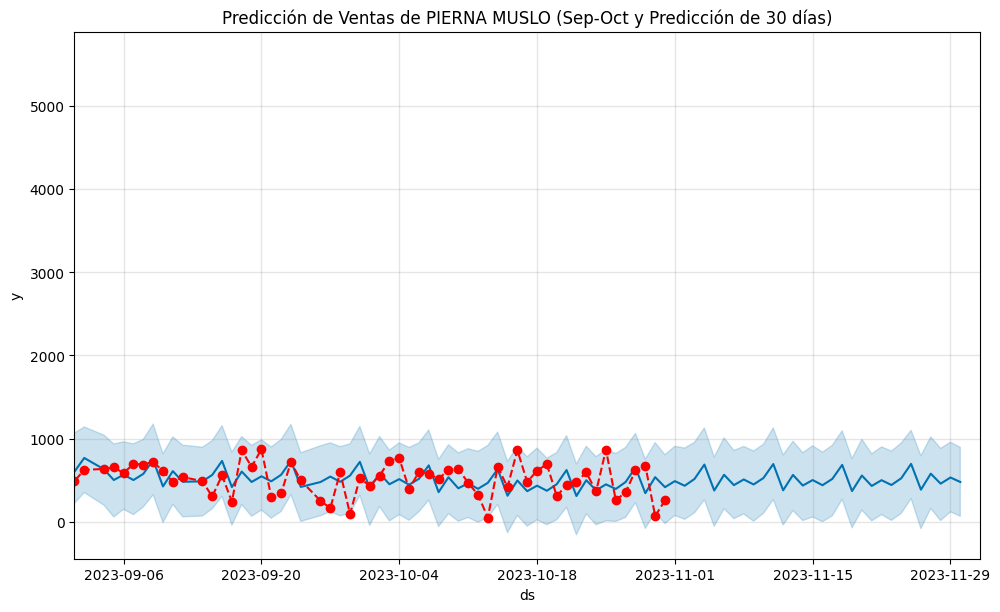

Predicción con todos los valores para PIERNA MUSLO:
            ds     yhat
945 2023-11-01 488.2888
946 2023-11-02 432.6835
947 2023-11-03 514.6530
948 2023-11-04 687.5348
949 2023-11-05 375.6917
950 2023-11-06 564.5632
951 2023-11-07 440.0465
952 2023-11-08 508.4404
953 2023-11-09 448.2339
954 2023-11-10 525.5634
955 2023-11-11 693.9305
956 2023-11-12 377.8574
957 2023-11-13 562.9335
958 2023-11-14 435.1917
959 2023-11-15 501.0481
960 2023-11-16 439.0864
961 2023-11-17 515.5125
962 2023-11-18 683.8690
963 2023-11-19 368.6901
964 2023-11-20 555.5464
965 2023-11-21 430.4221
966 2023-11-22 499.6553
967 2023-11-23 441.7248
968 2023-11-24 522.7075
969 2023-11-25 695.9962
970 2023-11-26 385.9592
971 2023-11-27 577.9899
972 2023-11-28 457.8891
973 2023-11-29 531.8112
974 2023-11-30 478.0563


In [35]:
# Definir las fechas de inicio y fin
fecha_inicio_str = '2023-09-01'
fecha_fin_str = '2023-12-02'

# Convertir las fechas a objetos datetime
fecha_inicio = datetime.strptime(fecha_inicio_str, '%Y-%m-%d')
fecha_fin = datetime.strptime(fecha_fin_str, '%Y-%m-%d')

# Iterar sobre los productos en dfs_de_productos_sumados_prophet
for product, product_df in dfs_de_productos_sumados_prophet.items():
    # Crear un modelo de Prophet
    modelo = Prophet()
    print(product_df)
    # Ajustar el modelo con los datos de entrenamiento
    modelo.fit(product_df)

    # Crear un DataFrame con fechas futuras para hacer la predicción
    futuro = modelo.make_future_dataframe(periods=30)

    # Hacer la predicción
    prediccion = modelo.predict(futuro)

    # Visualizar la predicción con límites ajustados
    fig = modelo.plot(prediccion)

    # Extraer los valores reales de predicción para cada día
    valores_prediccion = prediccion[['ds', 'yhat']].tail(30)

    # Mostrar el gráfico
    plt.plot(product_df['ds'], product_df['y'], label=f'Ventas reales de {product}', color='red', marker='o', linestyle='dashed')
    plt.xlim([fecha_inicio, fecha_fin])
    plt.title(f'Predicción de Ventas de {product} (Sep-Oct y Predicción de 30 días)')
    plt.show()

    # Mostrar el DataFrame con los valores de predicción
    print(f"Predicción con todos los valores para {product}:\n{valores_prediccion}")

    # Guardar las predicciones en dfs_noviembre_sumados
    col_name = f'P-V_PROPHET_{product}'
    dfs_noviembre_sumados[product][col_name] = valores_prediccion['yhat'].values

## EVALUAR PROPHET

Predicciones hechas sobre todas las ventas de los 10 producton contando con y sin las ventas de 2020

evaluacion sin 2020

In [36]:
# # Iterar sobre los productos en dfs_noviembre_sumados
# for product, product_df in dfs_noviembre_sumados.items():
#     # Crear un nombre único para la columna de predicciones de Prophet
#     col_name = f'P-V_PROPHET_{product}'

#     # Convertir la columna de fecha a tipo datetime
#     product_df['FechaMovimiento'] = pd.to_datetime(product_df.index)

#     # Fusionar el DataFrame de ventas con el DataFrame de predicciones
#     product_df = pd.merge(product_df, valores_prediccion[['ds', 'yhat']], left_on='FechaMovimiento', right_on='ds', how='left')

#     # Renombrar la columna yhat a Ventas_PROPHET
#     product_df.rename(columns={'yhat': col_name}, inplace=True)

#     # Opcional: Eliminar la columna adicional 'ds' si no la necesitas
#     product_df.drop(columns=['ds'], inplace=True)

#     # Actualizar el DataFrame en el diccionario
#     dfs_noviembre_sumados[product] = product_df

In [37]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df.head(30))

    # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
    evaluacion_metrica(dfs_noviembre_sumados[product]['MontoBase'], dfs_noviembre_sumados[product][f'P-V_PROPHET_{product}'])

                 NombreProducto  MontoBase  P-V_PROPHET_POLLO ESPECIAL
FechaMovimiento                                                       
2023-11-01       POLLO ESPECIAL  1999.7321                   1938.0934
2023-11-02       POLLO ESPECIAL  1011.2892                   1740.8432
2023-11-03       POLLO ESPECIAL  2343.7883                   1963.4582
2023-11-04       POLLO ESPECIAL  1673.2089                   2315.8646
2023-11-05       POLLO ESPECIAL  1181.9289                   1502.5276
2023-11-06       POLLO ESPECIAL   863.7984                   1889.2897
2023-11-07       POLLO ESPECIAL  1648.4580                   1762.6734
2023-11-08       POLLO ESPECIAL  1434.6711                   1835.1293
2023-11-09       POLLO ESPECIAL  1680.6493                   1619.1114
2023-11-10       POLLO ESPECIAL  1767.7892                   1824.6313
2023-11-11       POLLO ESPECIAL  1634.3693                   2162.0183
2023-11-12       POLLO ESPECIAL   773.2943                   1336.0989
2023-1

In [38]:
dfs_noviembre_sumados

{'POLLO ESPECIAL':                  NombreProducto  MontoBase  P-V_PROPHET_POLLO ESPECIAL
 FechaMovimiento                                                       
 2023-11-01       POLLO ESPECIAL  1999.7321                   1938.0934
 2023-11-02       POLLO ESPECIAL  1011.2892                   1740.8432
 2023-11-03       POLLO ESPECIAL  2343.7883                   1963.4582
 2023-11-04       POLLO ESPECIAL  1673.2089                   2315.8646
 2023-11-05       POLLO ESPECIAL  1181.9289                   1502.5276
 2023-11-06       POLLO ESPECIAL   863.7984                   1889.2897
 2023-11-07       POLLO ESPECIAL  1648.4580                   1762.6734
 2023-11-08       POLLO ESPECIAL  1434.6711                   1835.1293
 2023-11-09       POLLO ESPECIAL  1680.6493                   1619.1114
 2023-11-10       POLLO ESPECIAL  1767.7892                   1824.6313
 2023-11-11       POLLO ESPECIAL  1634.3693                   2162.0183
 2023-11-12       POLLO ESPECIAL   773.2943   

# LSTM


In [39]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [40]:
print(dfs_de_productos_sumados_lstm['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_de_productos_sumados_lstm)

NombreProducto     object
MontoBase         float64
DayOW               int64
Month               int64
Year                int64
dtype: object
{'POLLO ESPECIAL':                  NombreProducto  MontoBase  DayOW  Month  Year
FechaMovimiento                                               
2021-01-02       POLLO ESPECIAL  1822.6310      5      1  2021
2021-01-03       POLLO ESPECIAL   543.4340      6      1  2021
2021-01-04       POLLO ESPECIAL  1221.7920      0      1  2021
2021-01-05       POLLO ESPECIAL  1963.7850      1      1  2021
2021-01-06       POLLO ESPECIAL  1012.1080      2      1  2021
...                         ...        ...    ...    ...   ...
2023-10-27       POLLO ESPECIAL  2152.1624      4     10  2023
2023-10-28       POLLO ESPECIAL  2499.2891      5     10  2023
2023-10-29       POLLO ESPECIAL  1611.2471      6     10  2023
2023-10-30       POLLO ESPECIAL  3372.2990      0     10  2023
2023-10-31       POLLO ESPECIAL  2112.0323      1     10  2023

[998 rows x 5 col

In [41]:
# Función para crear secuencias temporales
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, label))
    return np.array([s[0] for s in sequences]), np.array([s[1] for s in sequences])


## Entrenamiento y prediccion para cada producto
Aquellos productos que despues de 01-09-2023 no tienen mas de 30 ventas, no tienen predicciones para el mes de Noviembre

Epoch 1/50
25/25 - 2s - loss: 0.0247 - 2s/epoch - 75ms/step
Epoch 2/50
25/25 - 0s - loss: 0.0166 - 207ms/epoch - 8ms/step
Epoch 3/50
25/25 - 0s - loss: 0.0162 - 209ms/epoch - 8ms/step
Epoch 4/50
25/25 - 0s - loss: 0.0160 - 189ms/epoch - 8ms/step
Epoch 5/50
25/25 - 0s - loss: 0.0162 - 191ms/epoch - 8ms/step
Epoch 6/50
25/25 - 0s - loss: 0.0159 - 211ms/epoch - 8ms/step
Epoch 7/50
25/25 - 0s - loss: 0.0165 - 208ms/epoch - 8ms/step
Epoch 8/50
25/25 - 0s - loss: 0.0159 - 209ms/epoch - 8ms/step
Epoch 9/50
25/25 - 0s - loss: 0.0160 - 198ms/epoch - 8ms/step
Epoch 10/50
25/25 - 0s - loss: 0.0159 - 190ms/epoch - 8ms/step
Epoch 11/50
25/25 - 0s - loss: 0.0160 - 193ms/epoch - 8ms/step
Epoch 12/50
25/25 - 0s - loss: 0.0159 - 216ms/epoch - 9ms/step
Epoch 13/50
25/25 - 0s - loss: 0.0158 - 195ms/epoch - 8ms/step
Epoch 14/50
25/25 - 0s - loss: 0.0158 - 202ms/epoch - 8ms/step
Epoch 15/50
25/25 - 0s - loss: 0.0161 - 189ms/epoch - 8ms/step
Epoch 16/50
25/25 - 0s - loss: 0.0162 - 200ms/epoch - 8ms/step
Epo

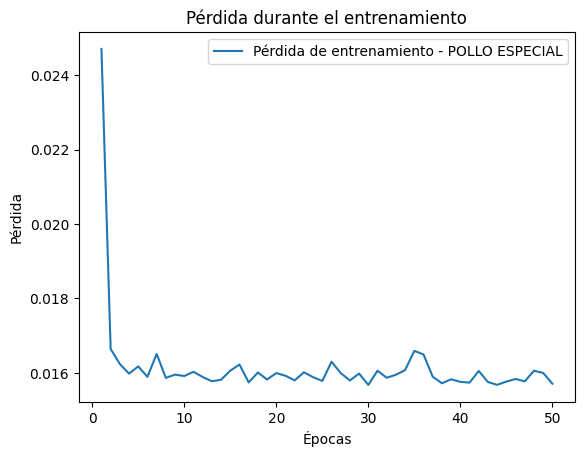

7/7 [==============================] - 0s 4ms/step


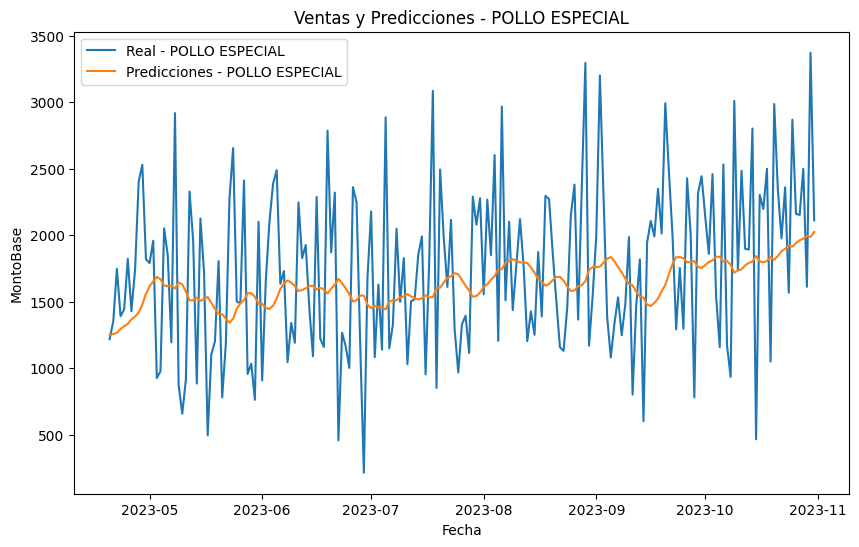

Dimensiones de fechas: (195,)
Dimensiones de predicciones: (194, 1)
La longitud de X_test es: 194 y la longitud de y_test es: 194
Forma de input_data: (30, 30, 1)
1/1 [==============================] - 0s 16ms/step
                 P-V_LSTM_POLLO ESPECIAL
FechaMovimiento                         
2023-11-01                             0
2023-11-02                             0
2023-11-03                             0
2023-11-04                             0
2023-11-05                             0
2023-11-06                             0
2023-11-07                             0
2023-11-08                             0
2023-11-09                             0
2023-11-10                             0
2023-11-11                             0
2023-11-12                             0
2023-11-13                             0
2023-11-14                             0
2023-11-15                             0
2023-11-16                             0
2023-11-17                             0
2023-1

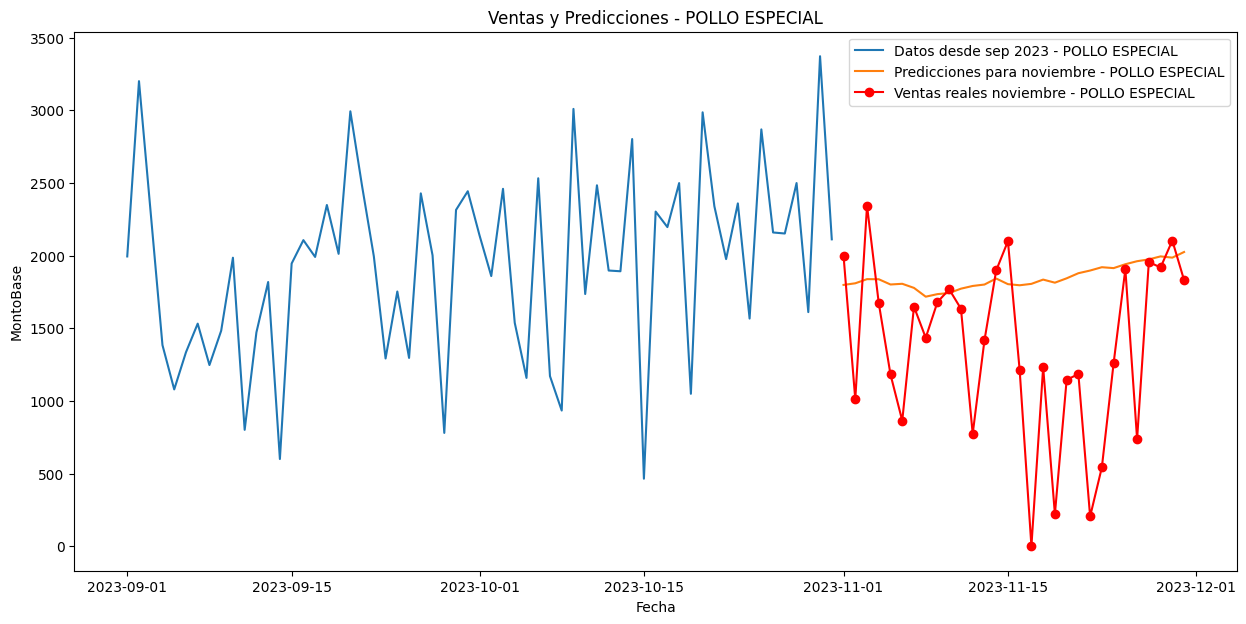

Epoch 1/50
24/24 - 1s - loss: 0.0196 - 1s/epoch - 62ms/step
Epoch 2/50
24/24 - 0s - loss: 0.0110 - 190ms/epoch - 8ms/step
Epoch 3/50
24/24 - 0s - loss: 0.0110 - 193ms/epoch - 8ms/step
Epoch 4/50
24/24 - 0s - loss: 0.0109 - 204ms/epoch - 9ms/step
Epoch 5/50
24/24 - 0s - loss: 0.0109 - 201ms/epoch - 8ms/step
Epoch 6/50
24/24 - 0s - loss: 0.0110 - 208ms/epoch - 9ms/step
Epoch 7/50
24/24 - 0s - loss: 0.0109 - 195ms/epoch - 8ms/step
Epoch 8/50
24/24 - 0s - loss: 0.0108 - 195ms/epoch - 8ms/step
Epoch 9/50
24/24 - 0s - loss: 0.0110 - 199ms/epoch - 8ms/step
Epoch 10/50
24/24 - 0s - loss: 0.0110 - 204ms/epoch - 9ms/step
Epoch 11/50
24/24 - 0s - loss: 0.0109 - 214ms/epoch - 9ms/step
Epoch 12/50
24/24 - 0s - loss: 0.0109 - 199ms/epoch - 8ms/step
Epoch 13/50
24/24 - 0s - loss: 0.0108 - 200ms/epoch - 8ms/step
Epoch 14/50
24/24 - 0s - loss: 0.0109 - 192ms/epoch - 8ms/step
Epoch 15/50
24/24 - 0s - loss: 0.0111 - 198ms/epoch - 8ms/step
Epoch 16/50
24/24 - 0s - loss: 0.0108 - 207ms/epoch - 9ms/step
Epo

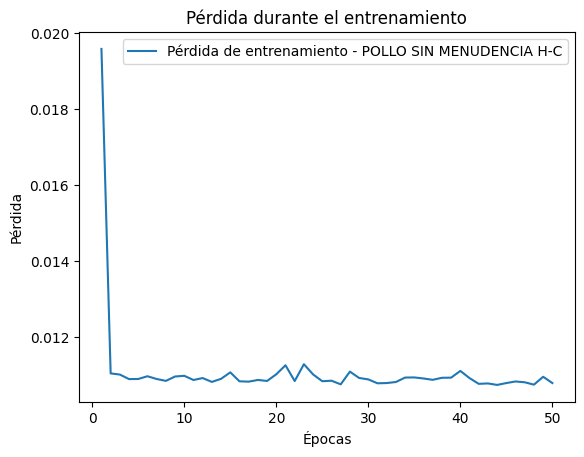

6/6 [==============================] - 0s 4ms/step


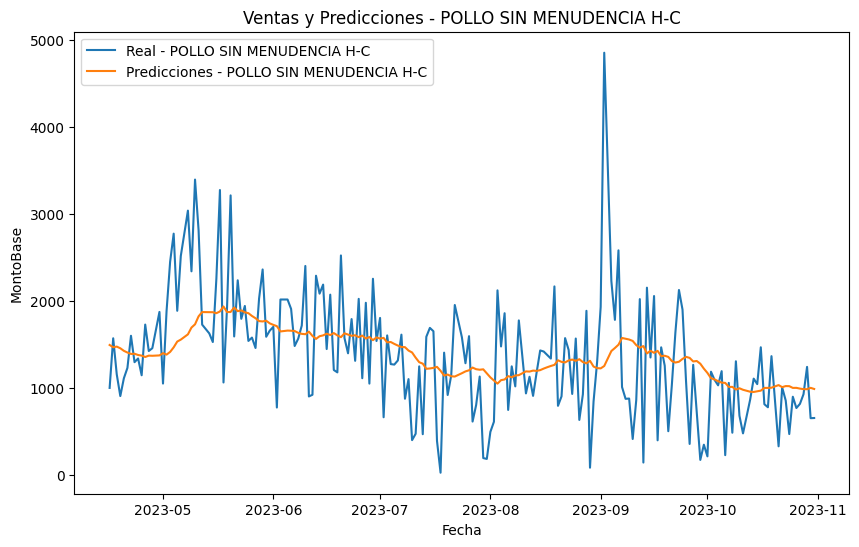

Dimensiones de fechas: (191,)
Dimensiones de predicciones: (190, 1)
La longitud de X_test es: 190 y la longitud de y_test es: 190
Forma de input_data: (30, 30, 1)
1/1 [==============================] - 0s 16ms/step
                 P-V_LSTM_POLLO SIN MENUDENCIA H-C
FechaMovimiento                                   
2023-11-01                                       0
2023-11-02                                       0
2023-11-03                                       0
2023-11-04                                       0
2023-11-05                                       0
2023-11-06                                       0
2023-11-07                                       0
2023-11-08                                       0
2023-11-09                                       0
2023-11-10                                       0
2023-11-11                                       0
2023-11-12                                       0
2023-11-13                                       0
2023-11-14          

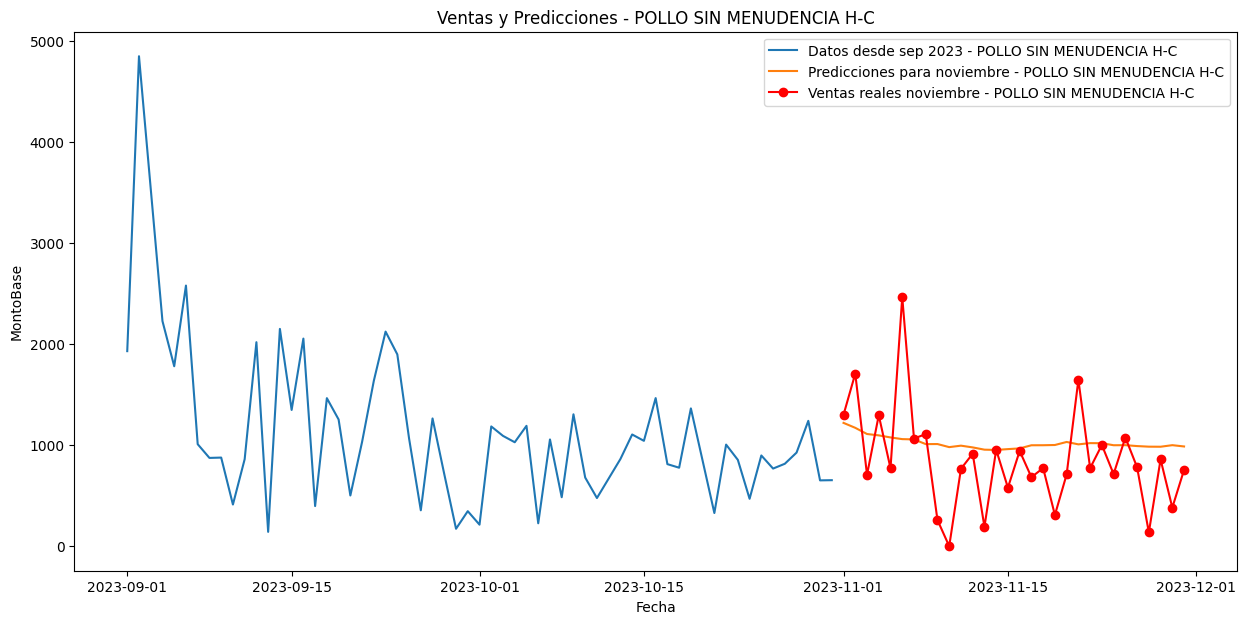

Epoch 1/50
23/23 - 2s - loss: 0.0066 - 2s/epoch - 66ms/step
Epoch 2/50
23/23 - 0s - loss: 0.0042 - 197ms/epoch - 9ms/step
Epoch 3/50
23/23 - 0s - loss: 0.0042 - 191ms/epoch - 8ms/step
Epoch 4/50
23/23 - 0s - loss: 0.0042 - 187ms/epoch - 8ms/step
Epoch 5/50
23/23 - 0s - loss: 0.0042 - 200ms/epoch - 9ms/step
Epoch 6/50
23/23 - 0s - loss: 0.0042 - 194ms/epoch - 8ms/step
Epoch 7/50
23/23 - 0s - loss: 0.0042 - 207ms/epoch - 9ms/step
Epoch 8/50
23/23 - 0s - loss: 0.0044 - 186ms/epoch - 8ms/step
Epoch 9/50
23/23 - 0s - loss: 0.0043 - 183ms/epoch - 8ms/step
Epoch 10/50
23/23 - 0s - loss: 0.0042 - 196ms/epoch - 9ms/step
Epoch 11/50
23/23 - 0s - loss: 0.0042 - 196ms/epoch - 9ms/step
Epoch 12/50
23/23 - 0s - loss: 0.0042 - 193ms/epoch - 8ms/step
Epoch 13/50
23/23 - 0s - loss: 0.0042 - 195ms/epoch - 8ms/step
Epoch 14/50
23/23 - 0s - loss: 0.0042 - 196ms/epoch - 9ms/step
Epoch 15/50
23/23 - 0s - loss: 0.0042 - 184ms/epoch - 8ms/step
Epoch 16/50
23/23 - 0s - loss: 0.0042 - 191ms/epoch - 8ms/step
Epo

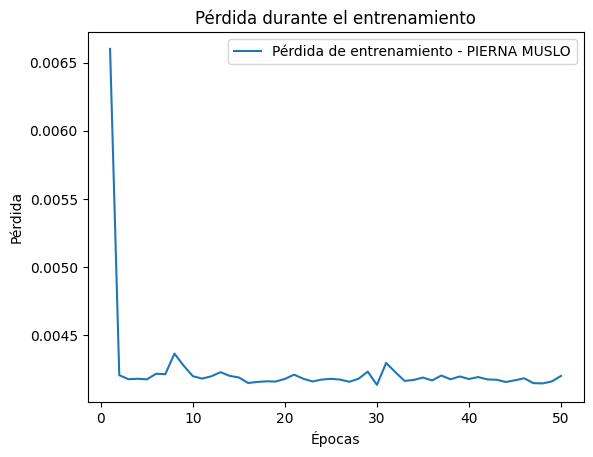

6/6 [==============================] - 0s 4ms/step


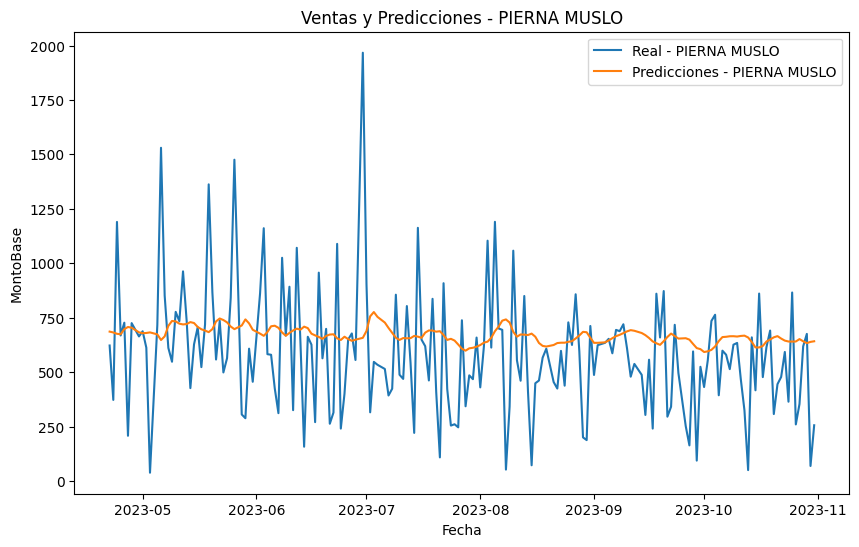

Dimensiones de fechas: (184,)
Dimensiones de predicciones: (183, 1)
La longitud de X_test es: 183 y la longitud de y_test es: 183
Forma de input_data: (30, 30, 1)
1/1 [==============================] - 0s 16ms/step
                 P-V_LSTM_PIERNA MUSLO
FechaMovimiento                       
2023-11-01                           0
2023-11-02                           0
2023-11-03                           0
2023-11-04                           0
2023-11-05                           0
2023-11-06                           0
2023-11-07                           0
2023-11-08                           0
2023-11-09                           0
2023-11-10                           0
2023-11-11                           0
2023-11-12                           0
2023-11-13                           0
2023-11-14                           0
2023-11-15                           0
2023-11-16                           0
2023-11-17                           0
2023-11-18                           0
2023-

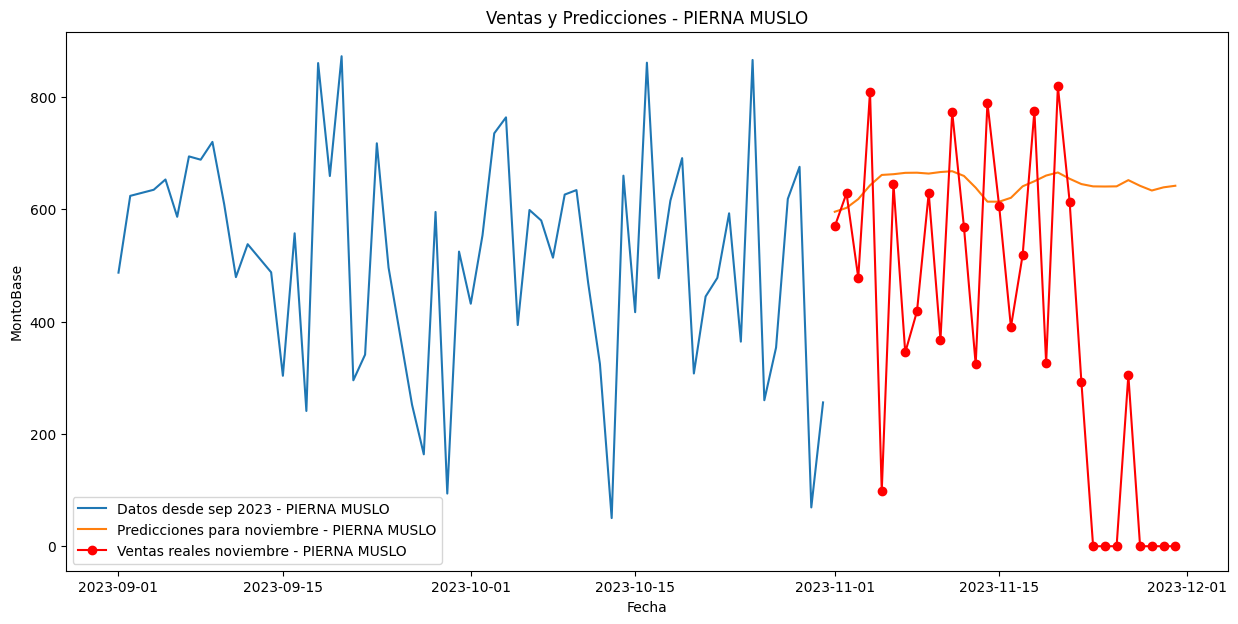

In [42]:
# Crear un DataFrame con fechas de noviembre y valores inicializados en 0
fechas_noviembre = pd.date_range(start='2023-11-01', end='2023-11-30')
# predicciones_df_lstm = pd.DataFrame()
# predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre
# predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_lstm
for product, product_df_lstm in dfs_de_productos_sumados_lstm.items():

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    product_df_lstm['MontoBase_scaler'] = scaler.fit_transform(product_df_lstm['MontoBase'].values.reshape(-1, 1))

    # Crear secuencias temporales
    seq_length = 30
    X, y = create_sequences(product_df_lstm['MontoBase_scaler'].values, seq_length)

    # Dividir en conjuntos de entrenamiento y prueba
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape para el modelo LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Construir el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

    # Visualizar la pérdida durante el entrenamiento
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label=f'Pérdida de entrenamiento - {product}')
    plt.title('Pérdida durante el entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
    # Hacer predicciones en el conjunto de prueba
    predictions = model.predict(X_test)

    # Desnormalizar las predicciones
    predictions = scaler.inverse_transform(predictions)

    # Visualizar las predicciones
    plt.figure(figsize=(10, 6))
    plt.plot(product_df_lstm.index[train_size+seq_length:], product_df_lstm['MontoBase'].values[train_size+seq_length:], label='Real - ' + product)
    plt.plot(product_df_lstm.index[train_size+seq_length:], predictions, label='Predicciones - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

    # Hacer predicciones para el futuro
    last_days = product_df_lstm.tail(60)  # Últimos 30 días
    input_data = last_days['MontoBase'].values
    input_data = scaler.transform(input_data.reshape(-1, 1))

    print("Dimensiones de fechas:", product_df_lstm.index[train_size+seq_length-1:].shape)
    print("Dimensiones de predicciones:", predictions.shape)
    print(f'La longitud de X_test es: {X_test.shape[0]} y la longitud de y_test es: {y_test.shape[0]}')

    input_data, _ = create_sequences(input_data, seq_length)

    # Imprimir la forma de input_data para depuración
    print("Forma de input_data:", input_data.shape)

    # Hacer predicciones para el futuro
    predictions_future = model.predict(input_data)
    #predictions_future_nov = model.predict(last_data)

    # Crear un DataFrame con fechas de noviembre y valores inicializados en 0
    predicciones_df_lstm = pd.DataFrame(index=fechas_noviembre)
    predicciones_df_lstm['FechaMovimiento'] = fechas_noviembre  # Agregar la columna de fechas
    predicciones_df_lstm.set_index('FechaMovimiento', inplace=True)
    predicciones_df_lstm[f'P-V_LSTM_{product}'] = 0

    # Imprimir el DataFrame inicial para depuración
    print(predicciones_df_lstm)

    # Desnormalizar las predicciones
    predictions_future = scaler.inverse_transform(predictions_future)

    # Actualizar las predicciones reales en las fechas correspondientes
    predicciones_df_lstm.loc[fechas_noviembre[:len(predictions_future)], f'P-V_LSTM_{product}'] = predictions_future.flatten()

    # Imprimir el DataFrame actualizado para depuración
    print(predicciones_df_lstm)

    # Agregar la columna al DataFrame original
    dfs_noviembre_sumados[product][f'P-V_LSTM_{product}'] = predicciones_df_lstm[f'P-V_LSTM_{product}']

    # Visualizar los resultados
    plt.figure(figsize=(15, 7))
    # Datos de venta desde el 1ro de septiembre de 2023
    start_date = '2023-09-01'
    end_date = '2023-11-30'
    plt.plot(product_df_lstm.index[product_df_lstm.index >= start_date], product_df_lstm['MontoBase'][product_df_lstm.index >= start_date], label='Datos desde sep 2023 - ' + product)
    # Predicciones para el futuro (noviembre)
    dates_future = pd.date_range(start='2023-11-01', periods=len(predictions_future))
    plt.plot(dates_future[:len(predictions_future)], predictions_future, label='Predicciones para noviembre - ' + product)
    # Datos reales de noviembre
    real_november_data = dfs_noviembre_sumados[product]
    plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
    plt.title('Ventas y Predicciones - ' + product)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend()
    plt.show()

In [43]:
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'].dtypes)
print(dfs_noviembre_sumados)

NombreProducto                           object
MontoBase                               float64
P-V_PROPHET_POLLO SIN MENUDENCIA H-C    float64
P-V_LSTM_POLLO SIN MENUDENCIA H-C       float32
dtype: object
{'POLLO ESPECIAL':                  NombreProducto  MontoBase  P-V_PROPHET_POLLO ESPECIAL  \
FechaMovimiento                                                          
2023-11-01       POLLO ESPECIAL  1999.7321                   1938.0934   
2023-11-02       POLLO ESPECIAL  1011.2892                   1740.8432   
2023-11-03       POLLO ESPECIAL  2343.7883                   1963.4582   
2023-11-04       POLLO ESPECIAL  1673.2089                   2315.8646   
2023-11-05       POLLO ESPECIAL  1181.9289                   1502.5276   
2023-11-06       POLLO ESPECIAL   863.7984                   1889.2897   
2023-11-07       POLLO ESPECIAL  1648.4580                   1762.6734   
2023-11-08       POLLO ESPECIAL  1434.6711                   1835.1293   
2023-11-09       POLLO ESPECIAL  16

## Evaluar LSTM




In [44]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_LSTM_{product}' existe
    if f'P-V_LSTM_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_LSTM_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 594967.9288988865
MAE is : 566.0767019140626
R2 is : -0.6381245141010197 %
------------------------------
MRSE is : 771.3416421397761
MAPE is : 95.13629687444603 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 246848.5241632437
MAE is : 369.85145590169265
R2 is : -0.010398559938899377 %
------------------------------
MRSE is : 496.83852926604203
MAPE is : 80.3569772687198 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: PIERNA MUSLO
Evaluation metric results:  
MSE is : 136596.7392317005
MAE is : 290.5685459472656
R2 is : -0.7429576425160174 %
------------------------------
MRS

# ARIMA

In [45]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.1 MB/s eta 0:00:00


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
#from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima import auto_arima

In [47]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].dtypes

NombreProducto     object
MontoBase         float64
dtype: object

In [48]:
dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 976 entries, 2021-01-02 to 2023-10-31
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NombreProducto  976 non-null    object 
 1   MontoBase       976 non-null    float64
dtypes: float64(1), object(1)
memory usage: 22.9+ KB


Predicciones para POLLO ESPECIAL:


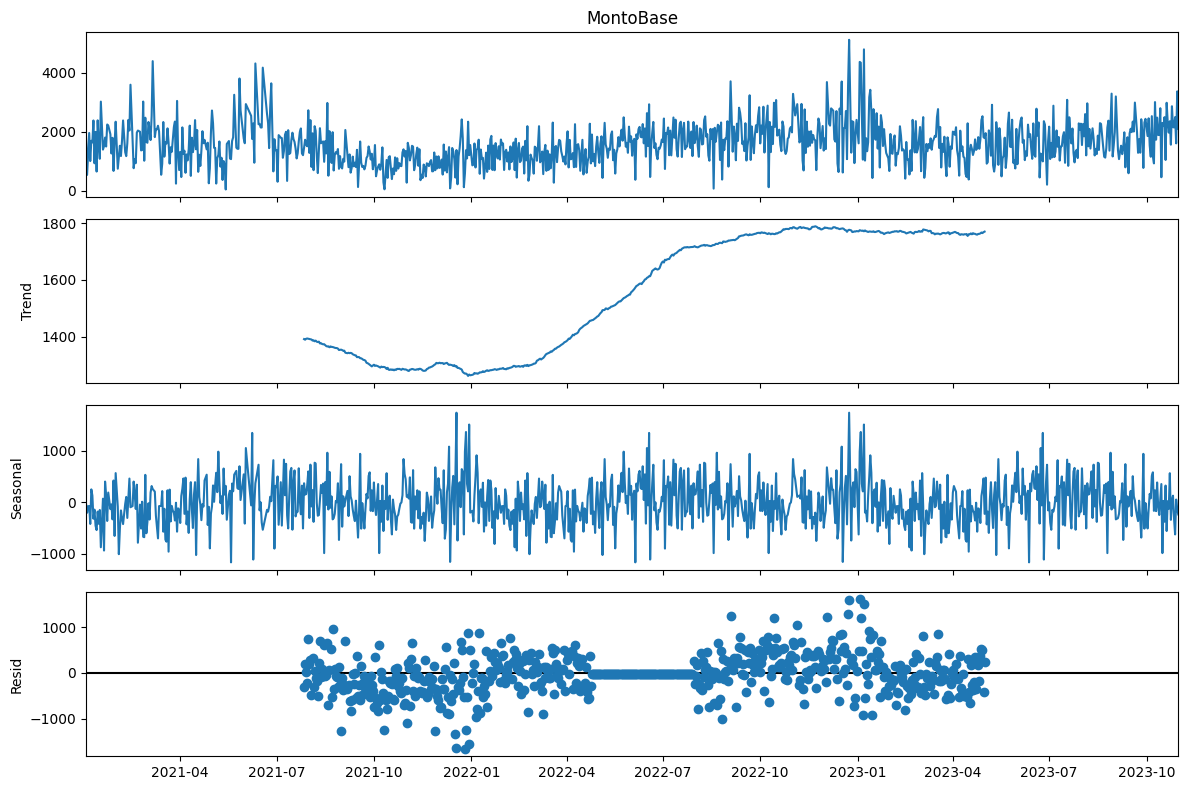

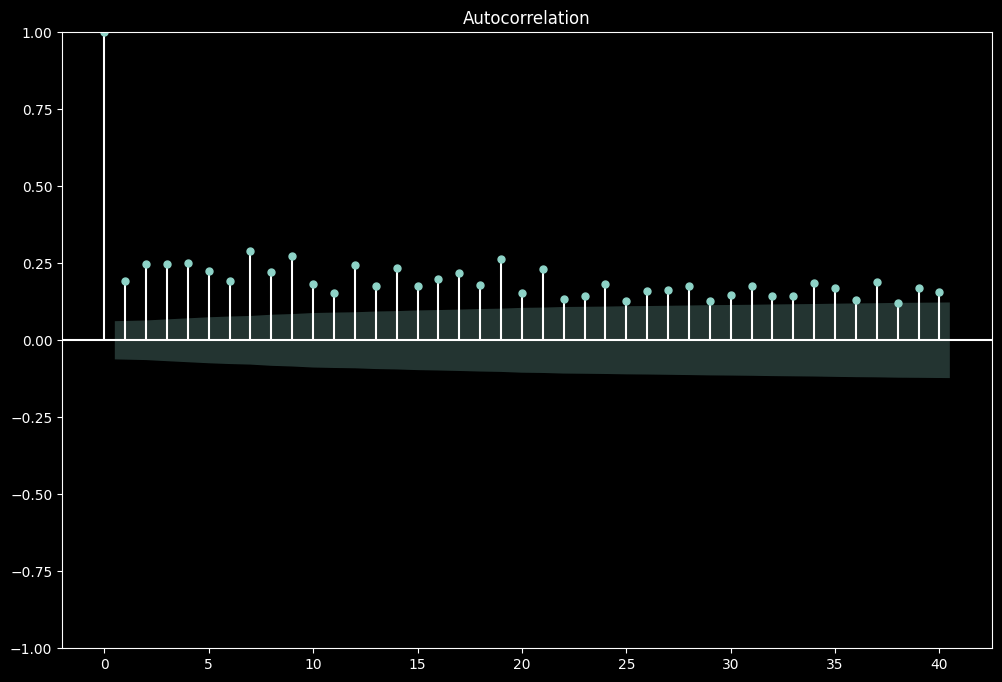

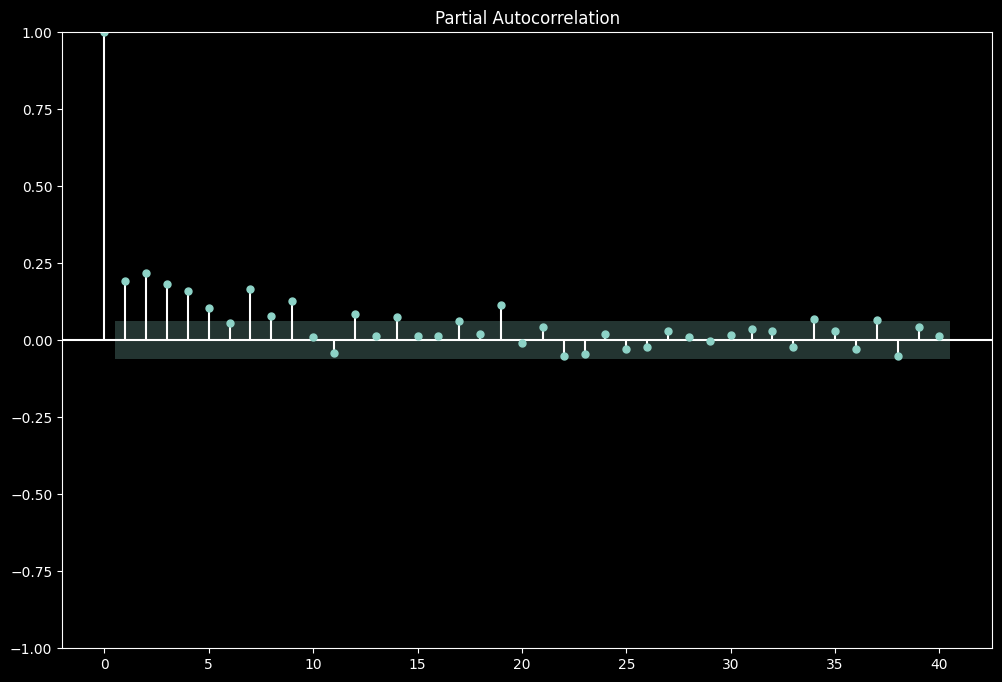

(967, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=16207.749, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=15678.735, Time=1.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.25 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=15931.072, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=15606.796, Time=6.57 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=19.94 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.95 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=15917.327, Time=1.14 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=15503.313, Time=3.96 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=15588.695, Time=1.87 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=9.14 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.97 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=15432.553, Time=3.92 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=15519.851, Time=2.61 sec
 ARIMA(3,1,0)(2,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

2023-10-01   2053.8400
2023-10-02   2499.3927
2023-10-03   2054.1145
2023-10-04   2370.6645
2023-10-05   2126.0380
2023-10-06   1801.3394
2023-10-07   1815.9498
2023-10-08   1999.0761
2023-10-09   2653.6881
2023-10-10   1697.8031
2023-10-11   2137.2063
2023-10-12   2371.5077
2023-10-13   2178.1069
2023-10-14   2574.2790
2023-10-15   2317.0324
2023-10-16   2432.9700
2023-10-17   1750.9538
2023-10-18   1985.2914
2023-10-19   1950.1833
2023-10-20   2008.3170
2023-10-21   2527.2309
2023-10-22   1829.0482
2023-10-23   2450.5824
2023-10-24   2688.7457
2023-10-25   2388.3461
2023-10-26   2980.3803
2023-10-27   2583.1442
2023-10-28   2579.4977
2023-10-29   2031.9207
2023-10-30   2155.8656
Freq: D, Name: ARIMA Predictions POLLO ESPECIAL, dtype: float64

Ventas reales y predicciones ARIMA para POLLO ESPECIAL:
                 MontoBase  P-V_ARIMA_POLLO ESPECIAL
FechaMovimiento                                     
2023-11-01       1999.7321                 2435.9100
2023-11-02       1011.2892    

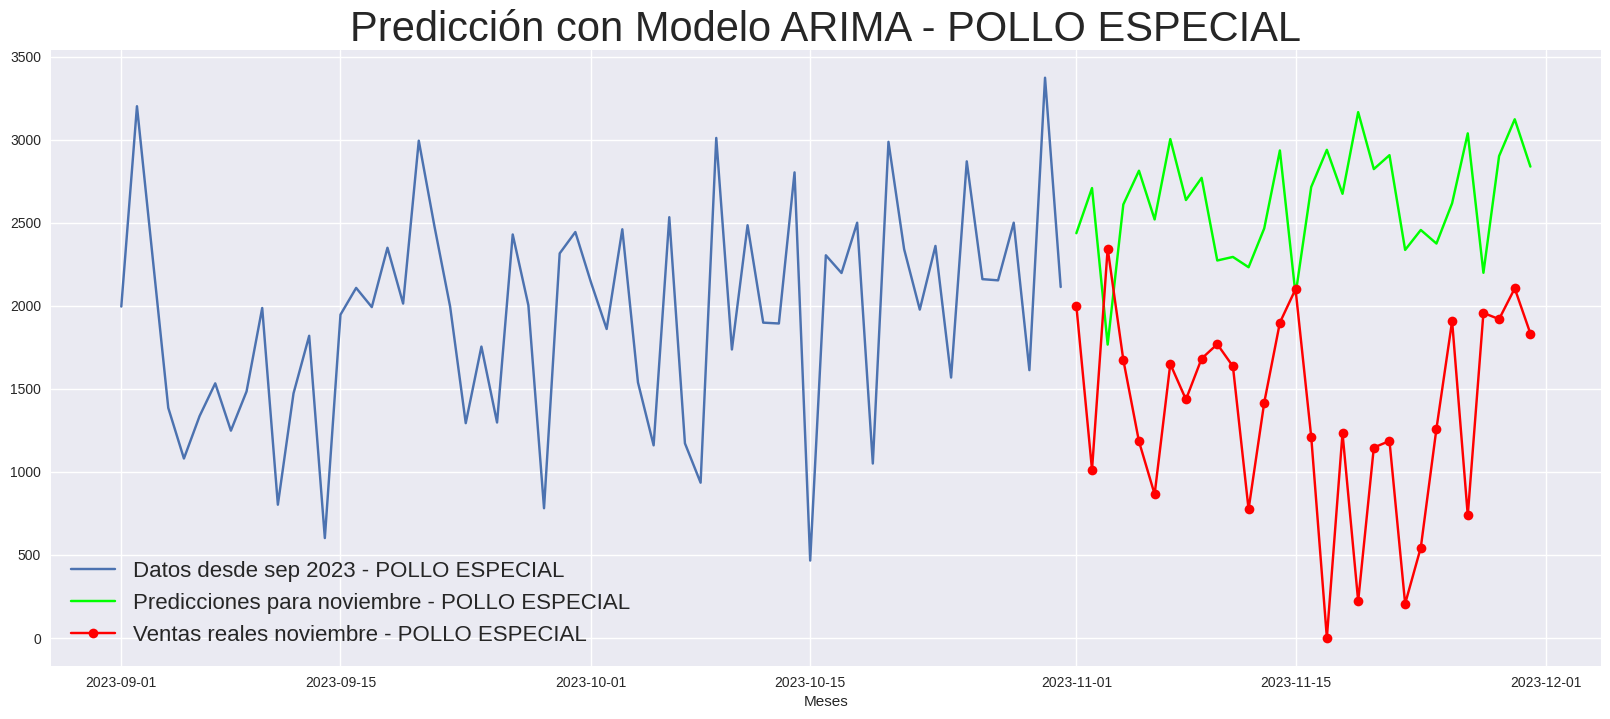

Predicciones para POLLO SIN MENUDENCIA H-C:


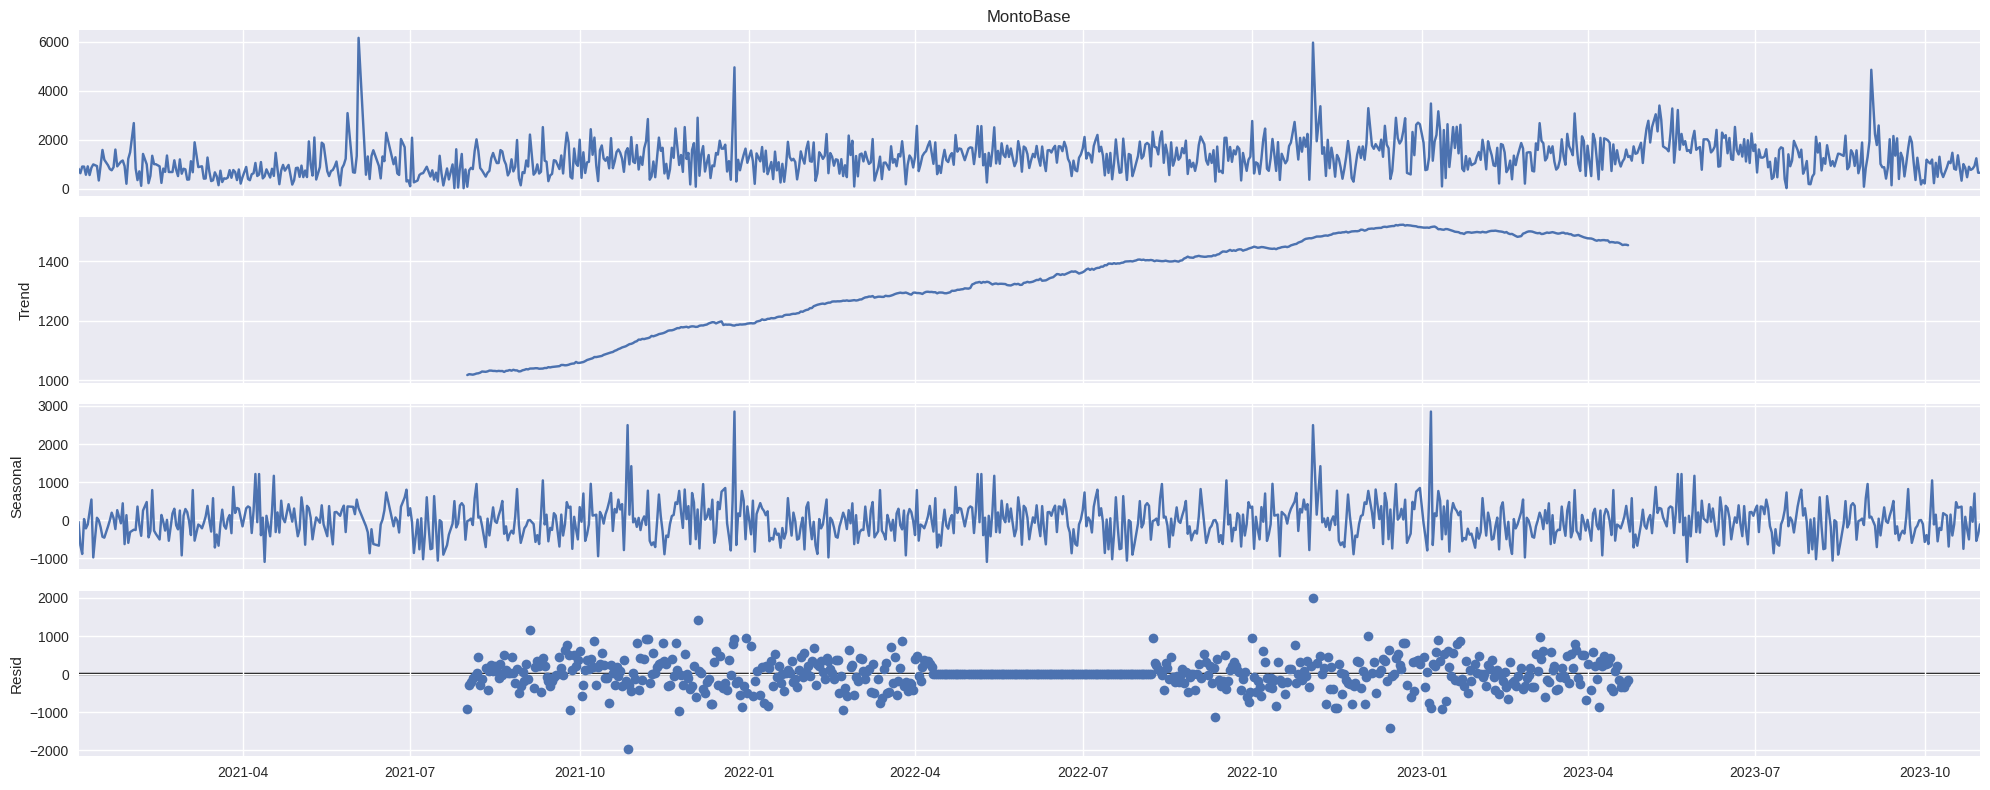

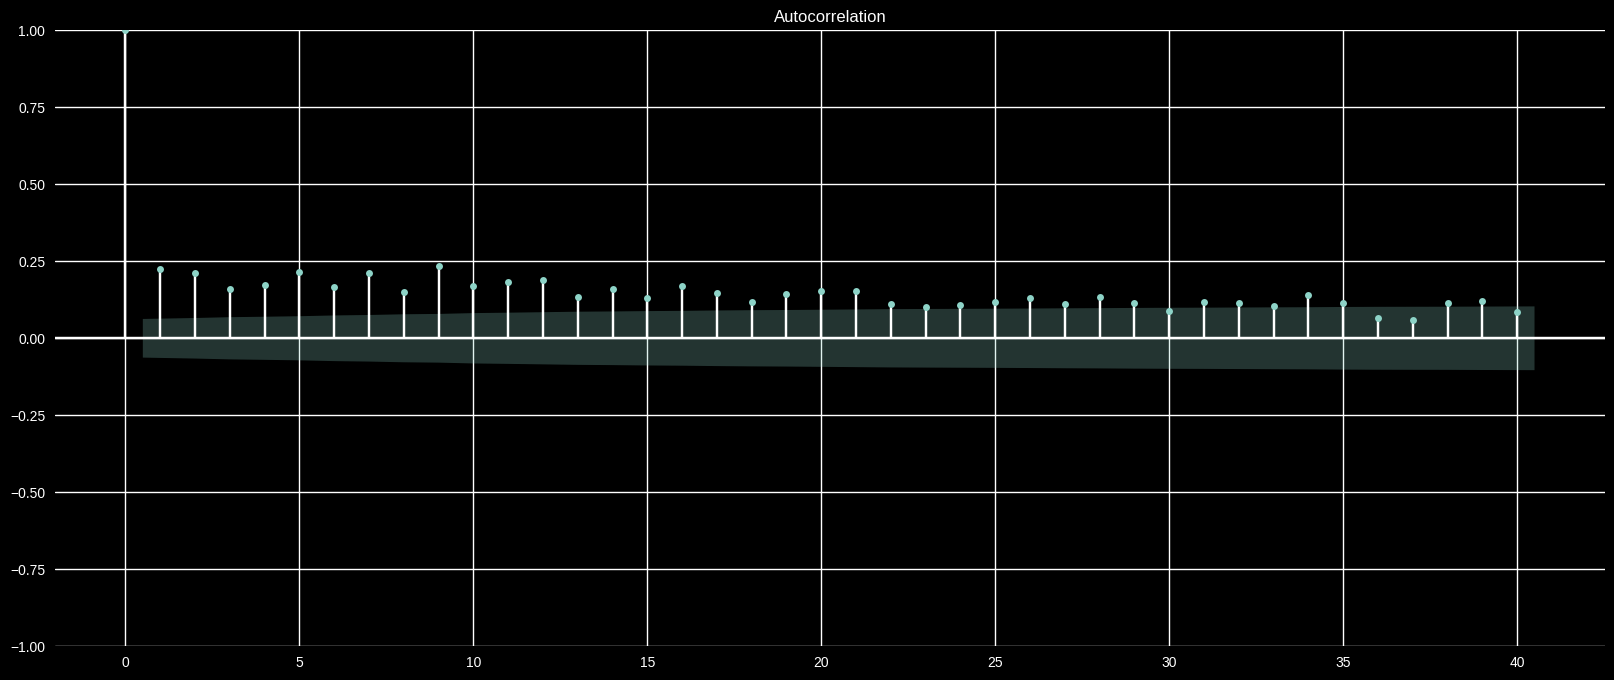

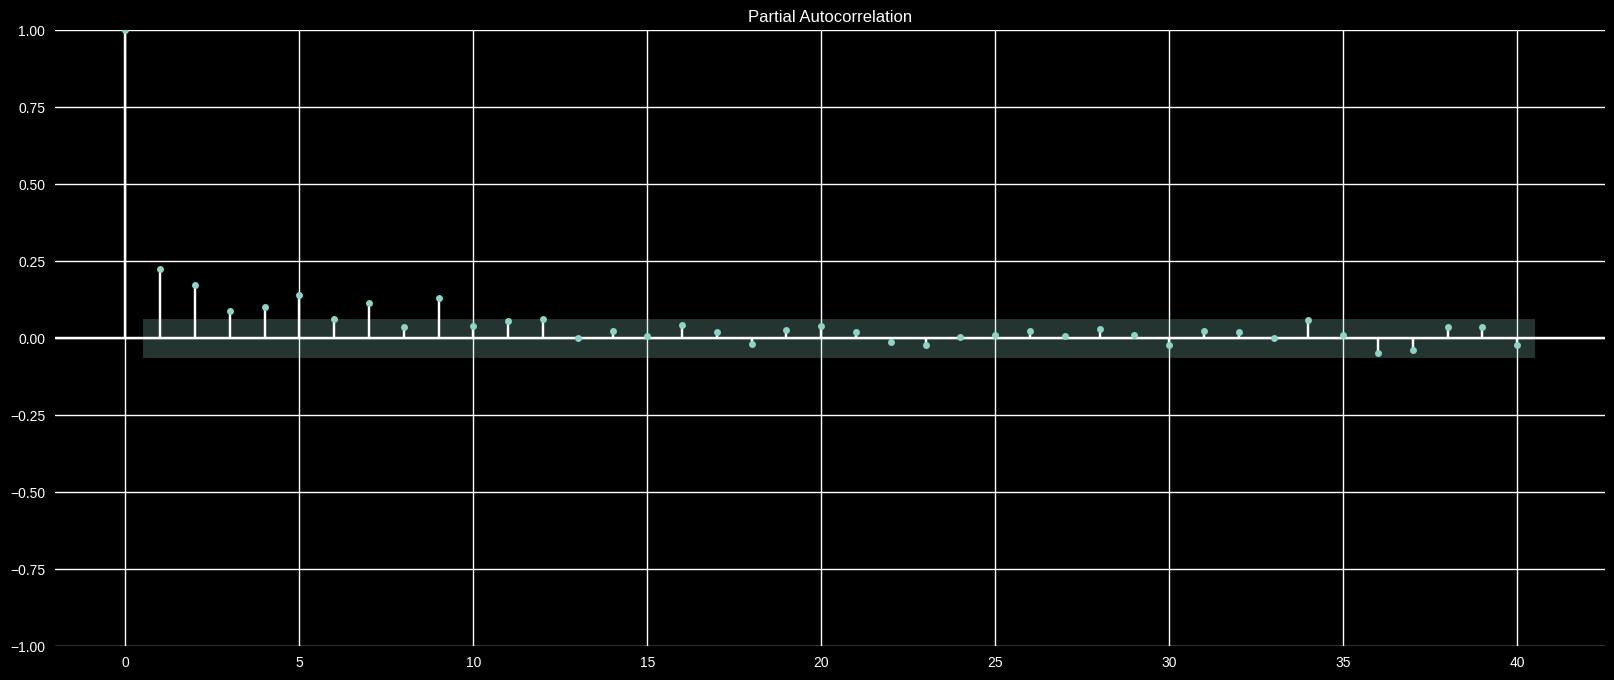

(945, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=15844.754, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=15351.608, Time=1.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=15593.093, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=15274.090, Time=3.24 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.00 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=15514.420, Time=0.62 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=15198.484, Time=3.94 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=15280.470, Time=1.48 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.08 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.09 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=15141.820, Time=4.87 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=15230.039, Time=1.97 sec
 ARIMA(3,1,0)(2,1,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

2023-09-29    855.5019
2023-09-30   1139.4260
2023-10-01    548.6601
2023-10-02   -221.9225
2023-10-03    109.7961
2023-10-04    554.6172
2023-10-05    428.5360
2023-10-06    899.4181
2023-10-07     72.2393
2023-10-08    642.2860
2023-10-09   1620.6082
2023-10-10    872.4086
2023-10-11    252.0811
2023-10-12    936.0617
2023-10-13    165.2591
2023-10-14   -406.5634
2023-10-15   -104.0884
2023-10-16    120.3047
2023-10-17    367.8899
2023-10-18    817.0107
2023-10-19   -331.1444
2023-10-20    256.9314
2023-10-21    673.8311
2023-10-22    430.9373
2023-10-23   -255.1110
2023-10-24    414.2575
2023-10-25   -127.9796
2023-10-26   -819.4575
2023-10-27   -437.9782
2023-10-28    -26.0986
Freq: D, Name: ARIMA Predictions POLLO SIN MENUDENCIA H-C, dtype: float64

Ventas reales y predicciones ARIMA para POLLO SIN MENUDENCIA H-C:
                 MontoBase  P-V_ARIMA_POLLO SIN MENUDENCIA H-C
FechaMovimiento                                               
2023-11-01       1301.7229                 

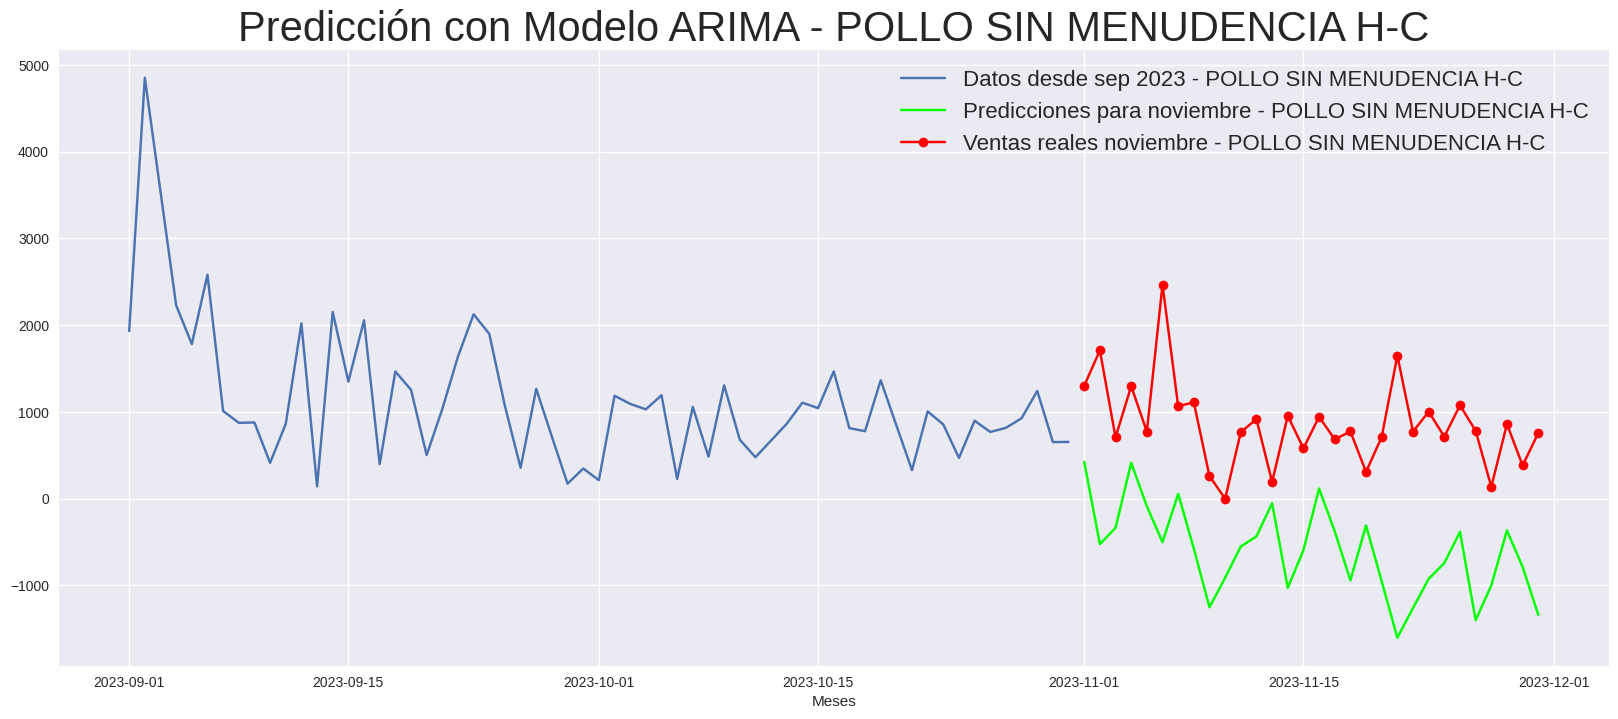

Predicciones para PIERNA MUSLO:


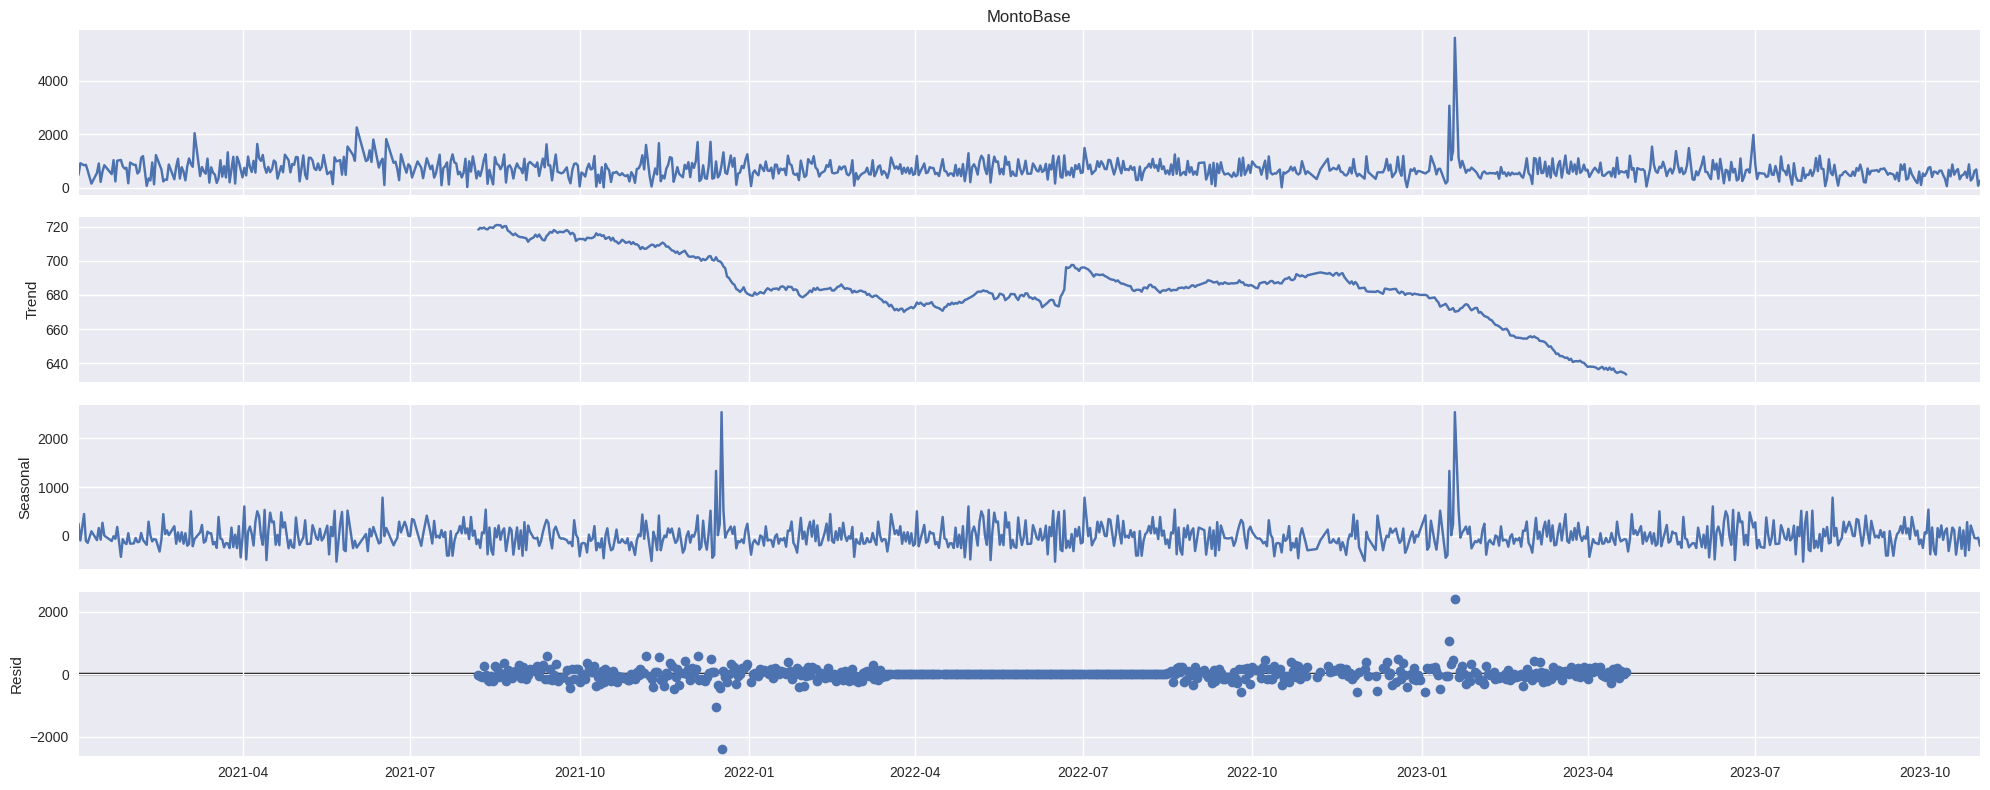

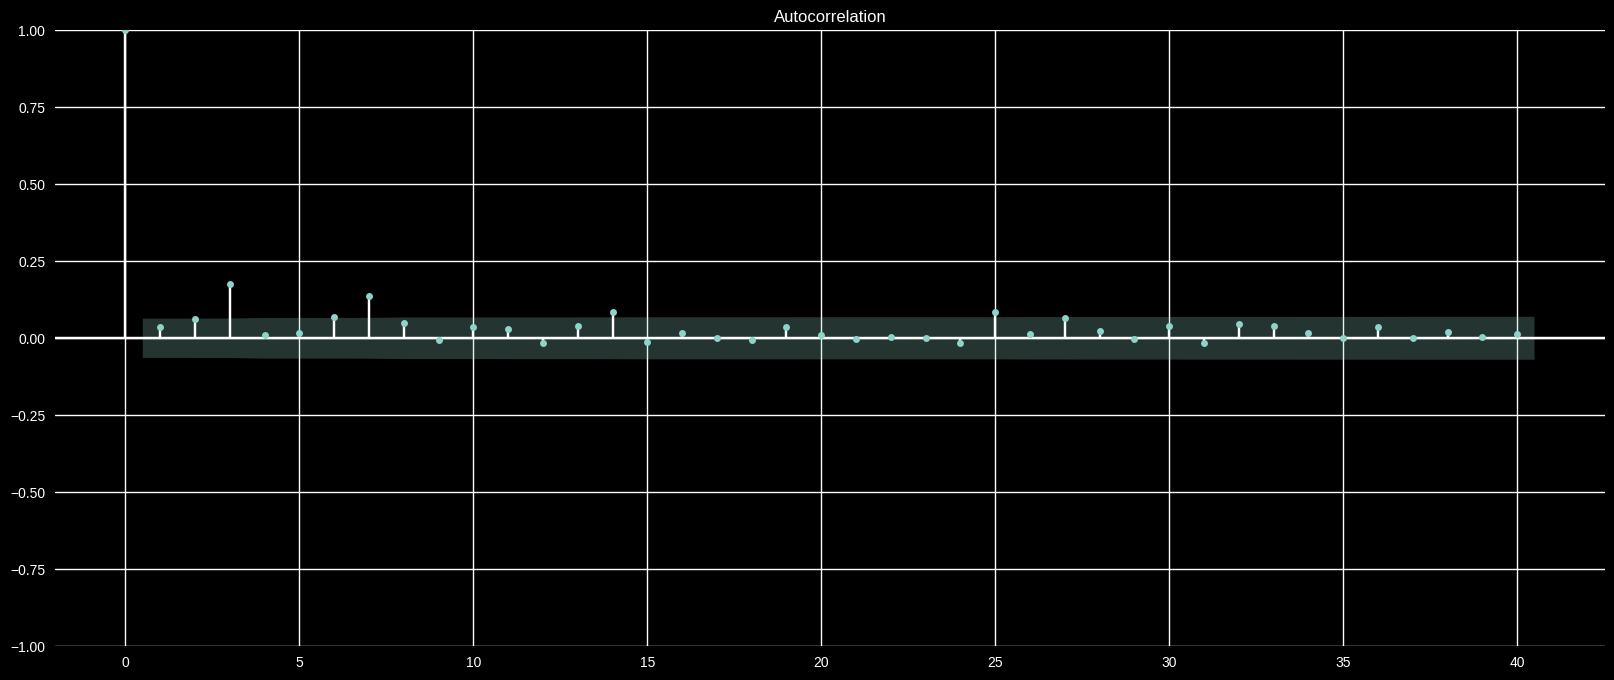

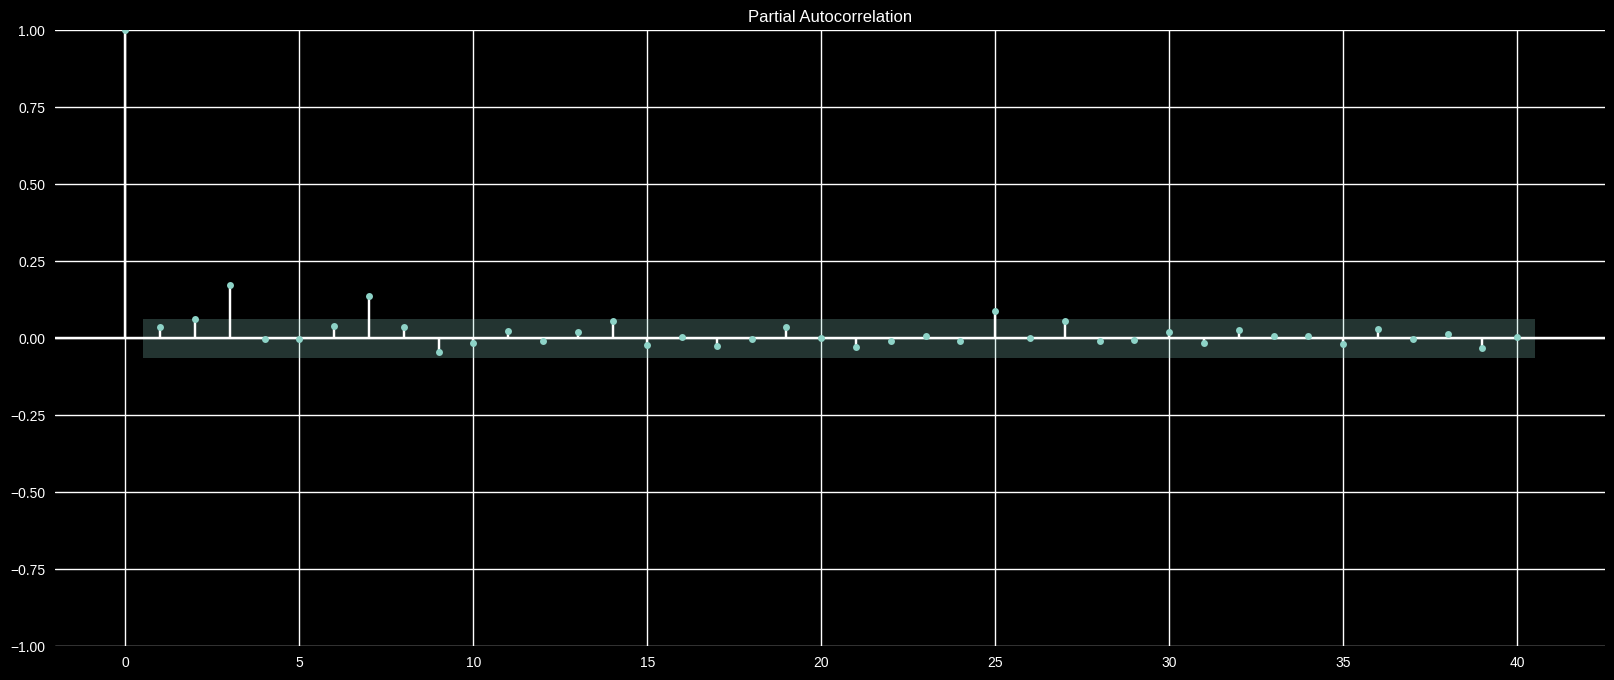

(914, 2) (31, 2)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=14403.912, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=13873.635, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=14147.415, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=13735.429, Time=1.50 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.36 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.58 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=14008.337, Time=0.34 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=13560.556, Time=1.86 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=13693.337, Time=0.78 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=7.80 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.12 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=13539.259, Time=1.67 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=13666.952, Time=0.93 sec
 ARIMA(3,1,0)(2,1,

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

2023-10-01   625.5034
2023-10-02   367.0360
2023-10-03   648.0000
2023-10-04   445.7749
2023-10-05   495.7479
2023-10-06   552.2269
2023-10-07   265.7713
2023-10-08   186.4346
2023-10-09   360.1085
2023-10-10   345.7745
2023-10-11   315.5373
2023-10-12   363.9684
2023-10-13   591.9974
2023-10-14   421.8216
2023-10-15   620.5631
2023-10-16   371.0218
2023-10-17   412.4767
2023-10-18   509.2369
2023-10-19   300.6392
2023-10-20   220.7101
2023-10-21   228.5751
2023-10-22   291.3539
2023-10-23   218.1772
2023-10-24   251.5592
2023-10-25   585.3450
2023-10-26   375.7432
2023-10-27   606.0099
2023-10-28   249.0276
2023-10-29   294.7887
2023-10-30   483.2480
Freq: D, Name: ARIMA Predictions PIERNA MUSLO, dtype: float64

Ventas reales y predicciones ARIMA para PIERNA MUSLO:
                 MontoBase  P-V_ARIMA_PIERNA MUSLO
FechaMovimiento                                   
2023-11-01        569.3420                104.1203
2023-11-02        628.4152                128.5749
2023-11-03        4

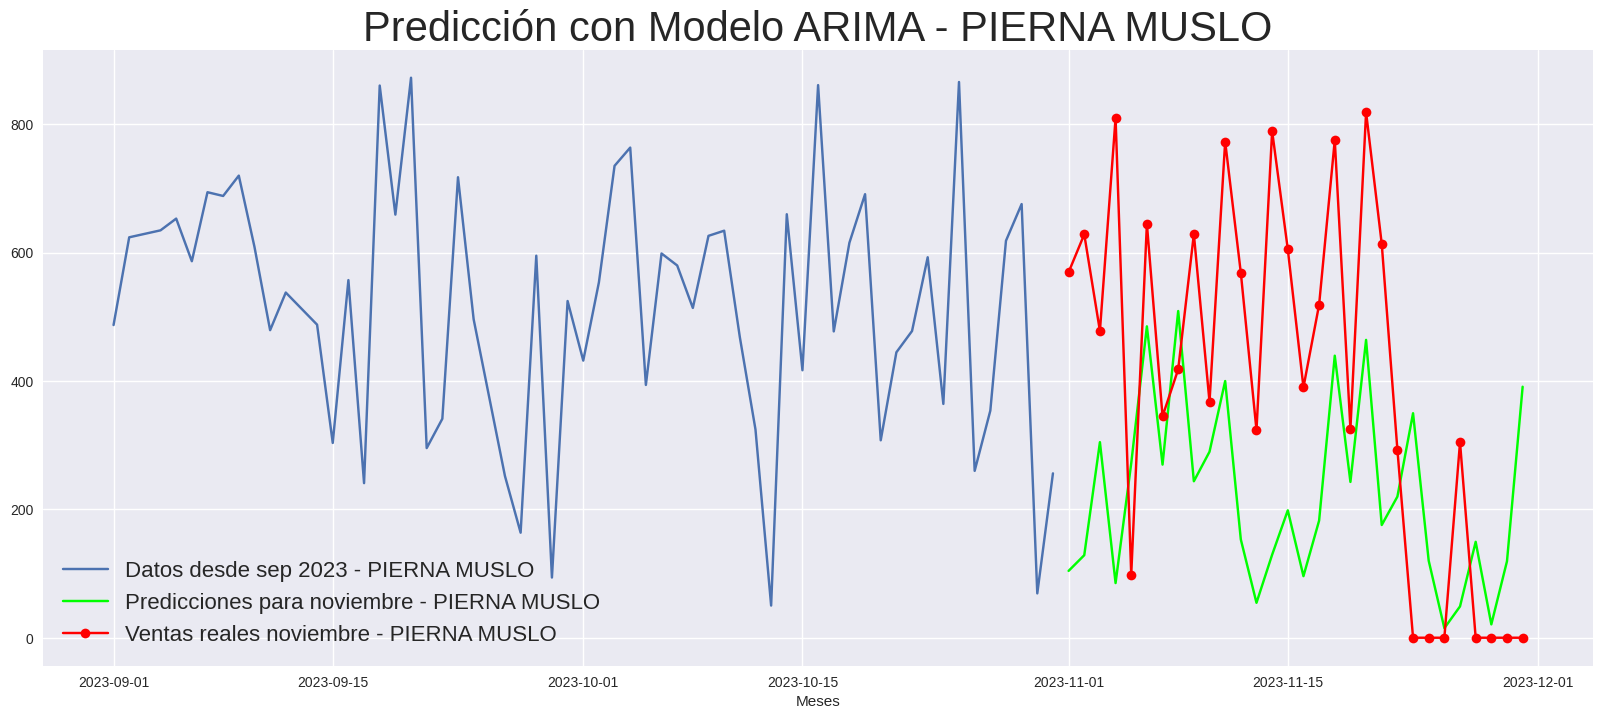

In [49]:
# Configurar tamaño de las figuras
plt.rcParams["figure.figsize"] = (12, 8)

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
arima_models = {}  # Diccionario para almacenar los modelos ARIMA de cada producto

# Iterar sobre los DataFrames en el objeto dfs_de_productos_sumados_arima
for product, product_df_arima in dfs_de_productos_sumados_arima.items():
    if len(product_df_arima) >= 365:
        # Aquí puedes poner el código para realizar la predicción con ARIMA
        print(f"Predicciones para {product}:")
        # Realizar descomposición estacional
        decomposition = seasonal_decompose(product_df_arima["MontoBase"], model="add", period=365)
        decomposition.plot();
        plt.show()

        # Visualizar ACF y PACF
        plt.style.use('dark_background')
        plot_acf(product_df_arima['MontoBase'], lags=40)
        plt.show()

        plot_pacf(product_df_arima['MontoBase'], lags=40)
        plt.show()

        # Dividir en orden cronológico, entrenando sin el mes de octubre
        train_size_arima = int(len(product_df_arima) - 31)
        train_arima, test_arima = product_df_arima[0:train_size_arima], product_df_arima[train_size_arima:]

        print(train_arima.shape, test_arima.shape)

        # Identificar el modelo ARIMA automáticamente
        modelo_auto = auto_arima(train_arima['MontoBase'],
                                 start_p=0, d=1, start_q=0,
                                #  max_p=5, max_d=2, max_q=5,
                                 start_P=0, D=1, start_Q=0,
                                #  max_P=2, max_D=1, max_Q=2,
                                 seasonal=True, m=12, trace=True,
                                 error_action='ignore', suppress_warnings=True, stepwise=True,
                                 random_state=20, n_fits=50
                                 )
        print(modelo_auto.summary())

        # Configurar el modelo ARIMA
        arima_model = SARIMAX(train_arima["MontoBase"], order=modelo_auto.order, seasonal_order=modelo_auto.seasonal_order)
        arima_result = arima_model.fit()
        arima_models[product] = arima_result  # Guardar el modelo en el diccionario

        # Hacer predicciones con ARIMA
        # arima_pred = arima_result.predict(start = len(product_df_arima) ,end=len(product_df_arima)+29, typ="levels").rename(f"ARIMA Predictions {product}")
        arima_pred = arima_result.predict(start=len(train_arima), end=len(train_arima) + 29, typ="levels").rename(f"ARIMA Predictions {product}")

        # Crear un índice para las predicciones de noviembre
        # november_index = pd.date_range(start=train_arima.index[-1] + pd.DateOffset(1), periods=30)
        november_index = pd.date_range(start=test_arima.index[0], periods=30)
        arima_pred.index = november_index

        # print(f'el ultimo indice_valor de los datos reales es: {len(train_arima)},')
        # print(f'se supone que deeria acabar 30 despues, pero la funcion indica: {len(train_arima) + 29} \n')

        # Imprimir las predicciones para el mes de noviembre
        print(arima_pred)

        # Agregar las predicciones al DataFrame original
        if product in arima_models:
            # Hacer predicciones con ARIMA para el DataFrame actual
            arima_pred_full = arima_models[product].predict(start=len(product_df_arima), end=len(product_df_arima) + 29, typ="levels").rename(f"P-V_ARIMA_{product}")

            # Asegurarse de que las predicciones se alineen correctamente con las fechas de noviembre
            arima_pred_full.index = dfs_noviembre_sumados[product].index

            # Agregar la columna de predicciones ARIMA al DataFrame actual
            dfs_noviembre_sumados[product][f"P-V_ARIMA_{product}"] = arima_pred_full

            # Imprimir el resultado
            print(f'\nVentas reales y predicciones ARIMA para {product}:')
            print(dfs_noviembre_sumados[product][['MontoBase', f'P-V_ARIMA_{product}']].head(20))
        else:
            print(f"No hay modelo ARIMA para {product}.")

        # Visualizar las predicciones y los datos reales
        plt.style.use('seaborn')
        plt.rcParams["figure.figsize"] = (20, 8)
        # Datos de venta desde el 1ro de septiembre de 2023
        # Convertir la cadena a un objeto datetime.date
        start_date = datetime.strptime('2023-09-01', '%Y-%m-%d').date()
        end_date = datetime.strptime('2023-11-30', '%Y-%m-%d').date()
        plt.plot(product_df_arima.index[product_df_arima.index >= start_date], product_df_arima['MontoBase'][product_df_arima.index >= start_date], label='Datos desde sep 2023 - ' + product)
        # Predicciones para el futuro (noviembre)
        dates_future = pd.date_range(start='2023-11-01', periods=len(arima_pred_full))
        plt.plot(dates_future[:len(arima_pred_full)], arima_pred_full, color="lime", label='Predicciones para noviembre - ' + product)
        real_november_data = dfs_noviembre_sumados[product]
        plt.plot(real_november_data.index, real_november_data['MontoBase'], 'o-', color='red', label='Ventas reales noviembre - ' + product)
        plt.title(f"Predicción con Modelo ARIMA - {product}", fontsize=30)
        plt.xlabel('Meses')
        plt.ylabel('')
        plt.legend(fontsize=16)
        plt.show()
    else:
        print(f"No hay suficientes datos para hacer una predicción con ARIMA para {product}.")

In [50]:
#print(dfs_de_productos_sumados_arima['POLLO SIN MENUDENCIA H-C'])
print(dfs_noviembre_sumados['POLLO SIN MENUDENCIA H-C'])

                           NombreProducto  MontoBase  \
FechaMovimiento                                        
2023-11-01       POLLO SIN MENUDENCIA H-C  1301.7229   
2023-11-02       POLLO SIN MENUDENCIA H-C  1709.2895   
2023-11-03       POLLO SIN MENUDENCIA H-C   707.2652   
2023-11-04       POLLO SIN MENUDENCIA H-C  1296.7834   
2023-11-05       POLLO SIN MENUDENCIA H-C   772.3420   
2023-11-06       POLLO SIN MENUDENCIA H-C  2467.2758   
2023-11-07       POLLO SIN MENUDENCIA H-C  1066.5938   
2023-11-08       POLLO SIN MENUDENCIA H-C  1110.0792   
2023-11-09       POLLO SIN MENUDENCIA H-C   259.3104   
2023-11-10       POLLO SIN MENUDENCIA H-C     0.0000   
2023-11-11       POLLO SIN MENUDENCIA H-C   766.5036   
2023-11-12       POLLO SIN MENUDENCIA H-C   916.6644   
2023-11-13       POLLO SIN MENUDENCIA H-C   191.7683   
2023-11-14       POLLO SIN MENUDENCIA H-C   955.1658   
2023-11-15       POLLO SIN MENUDENCIA H-C   579.8350   
2023-11-16       POLLO SIN MENUDENCIA H-C   943.

In [51]:
# ESTO ES PARA ELIMINAR LA COLUMA DE PREDICCION DE ARIMA QUE aparecia con 'nan'
# for product, product_df in dfs_noviembre_sumados.items():
#     product_df.drop(columns=[f'P-V_ARIMA_{product}'], inplace=True)
#     print(product_df)


## Evaluar ARIMA

In [52]:
for product, product_df in dfs_noviembre_sumados.items():
    # print(product_df.head(30))

    # Verificar si la columna 'P-V_ARIMA_{product}' existe
    if f'P-V_ARIMA_{product}' in dfs_noviembre_sumados[product].columns:
        print(f'evaluacion del producto: {product}')
        # Puedes acceder a cada DataFrame individualmente para realizar evaluaciones métricas
        evaluacion_metrica(
            dfs_noviembre_sumados[product]['MontoBase'],
            dfs_noviembre_sumados[product][f'P-V_ARIMA_{product}']
        )
        print('\n')
    else:
        print(f"No hay predicciones para {product}.")

evaluacion del producto: POLLO ESPECIAL
Evaluation metric results:  
MSE is : 2161471.99246438
MAE is : 1298.5011590928807
R2 is : -4.951178349985347 %
------------------------------
MRSE is : 1470.1945423869522
MAPE is : 175.28495696105202 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: POLLO SIN MENUDENCIA H-C
Evaluation metric results:  
MSE is : 2566045.415155118
MAE is : 1462.6178680415355
R2 is : -9.503318182676052 %
------------------------------
MRSE is : 1601.8880782236686
MAPE is : 208.9112008489833 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------




evaluacion del producto: PIERNA MUSLO
Evaluation metric results:  
MSE is : 108825.07599501646
MAE is : 276.180651924201
R2 is : -0.3885946250968866 %
------------------------------
MRSE

Cómo interpretar las gráficas de residuos en el modelo ARIMA


# PREDICCIONES
### Graficos y valores calculados de (todos) los productos


<ipython-input-53-18dcb7d60c8b>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


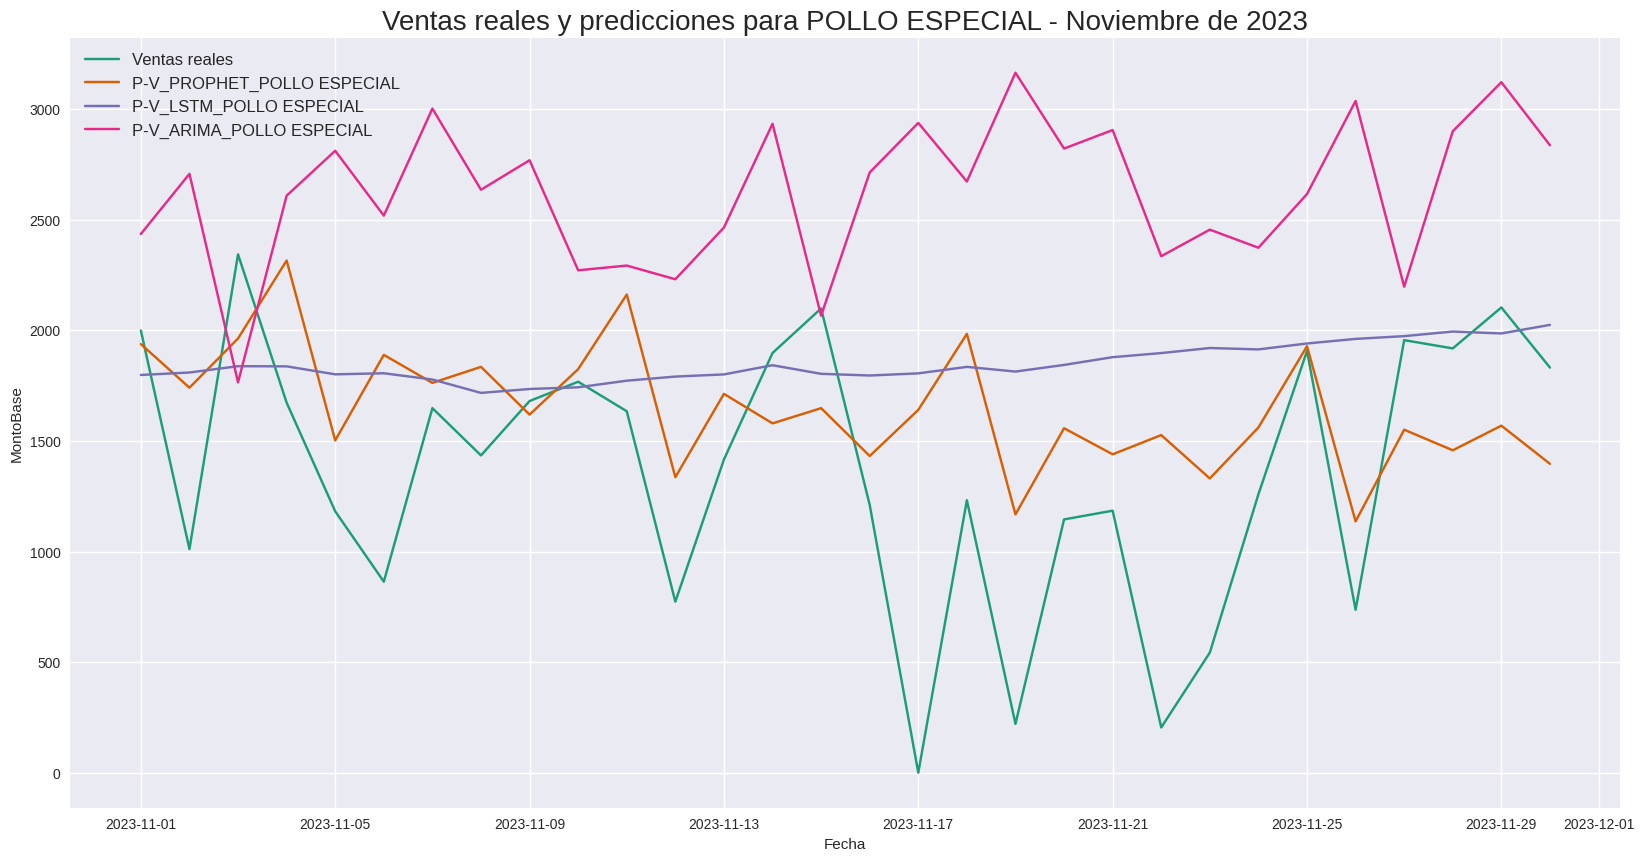

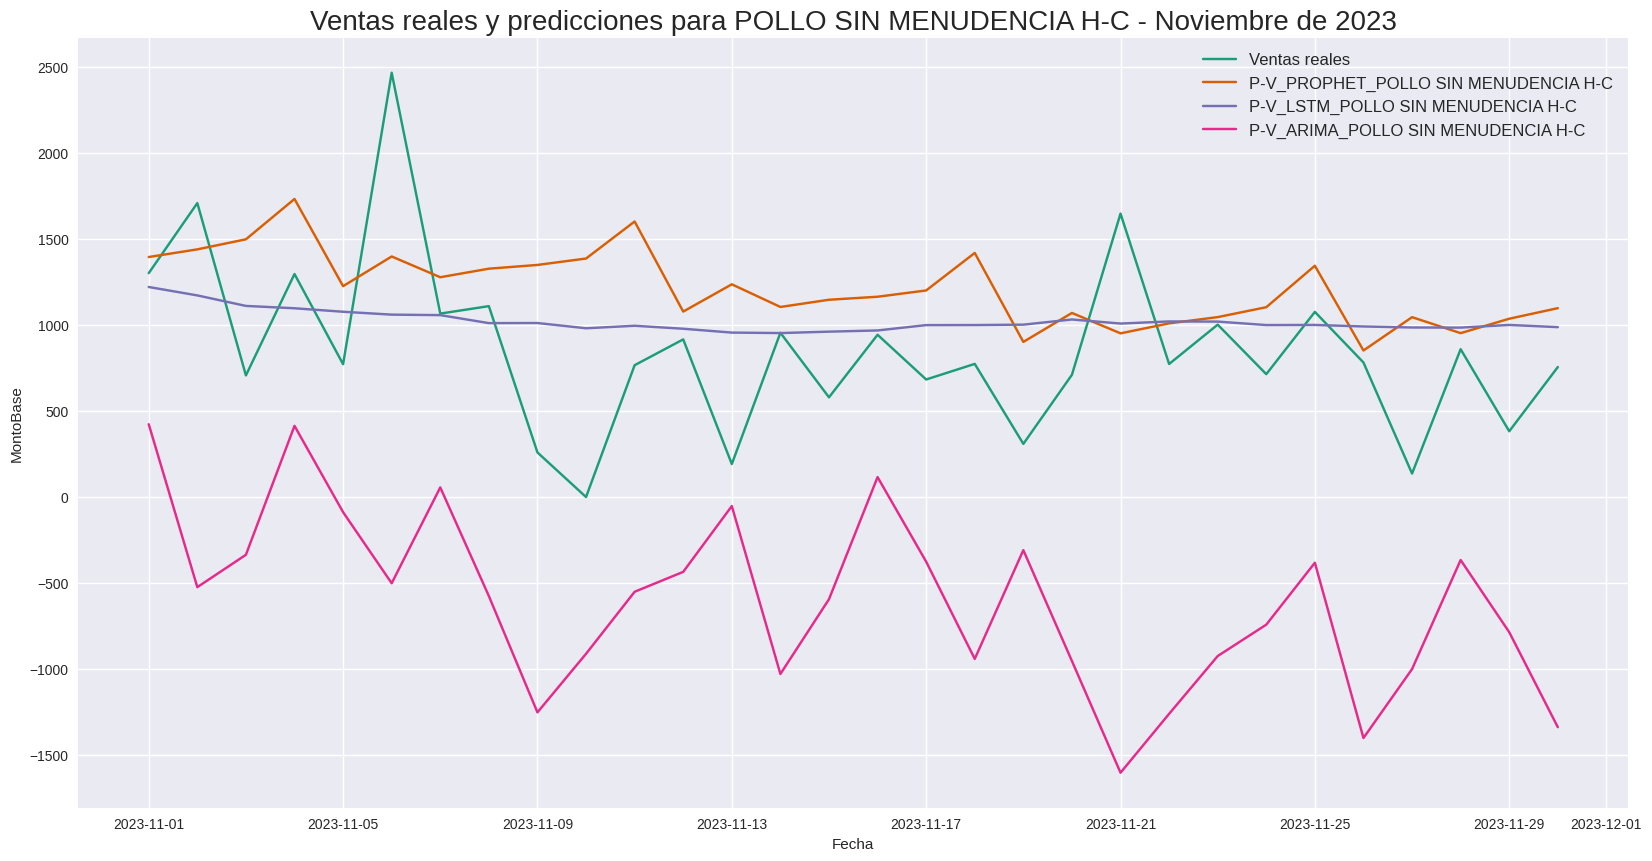

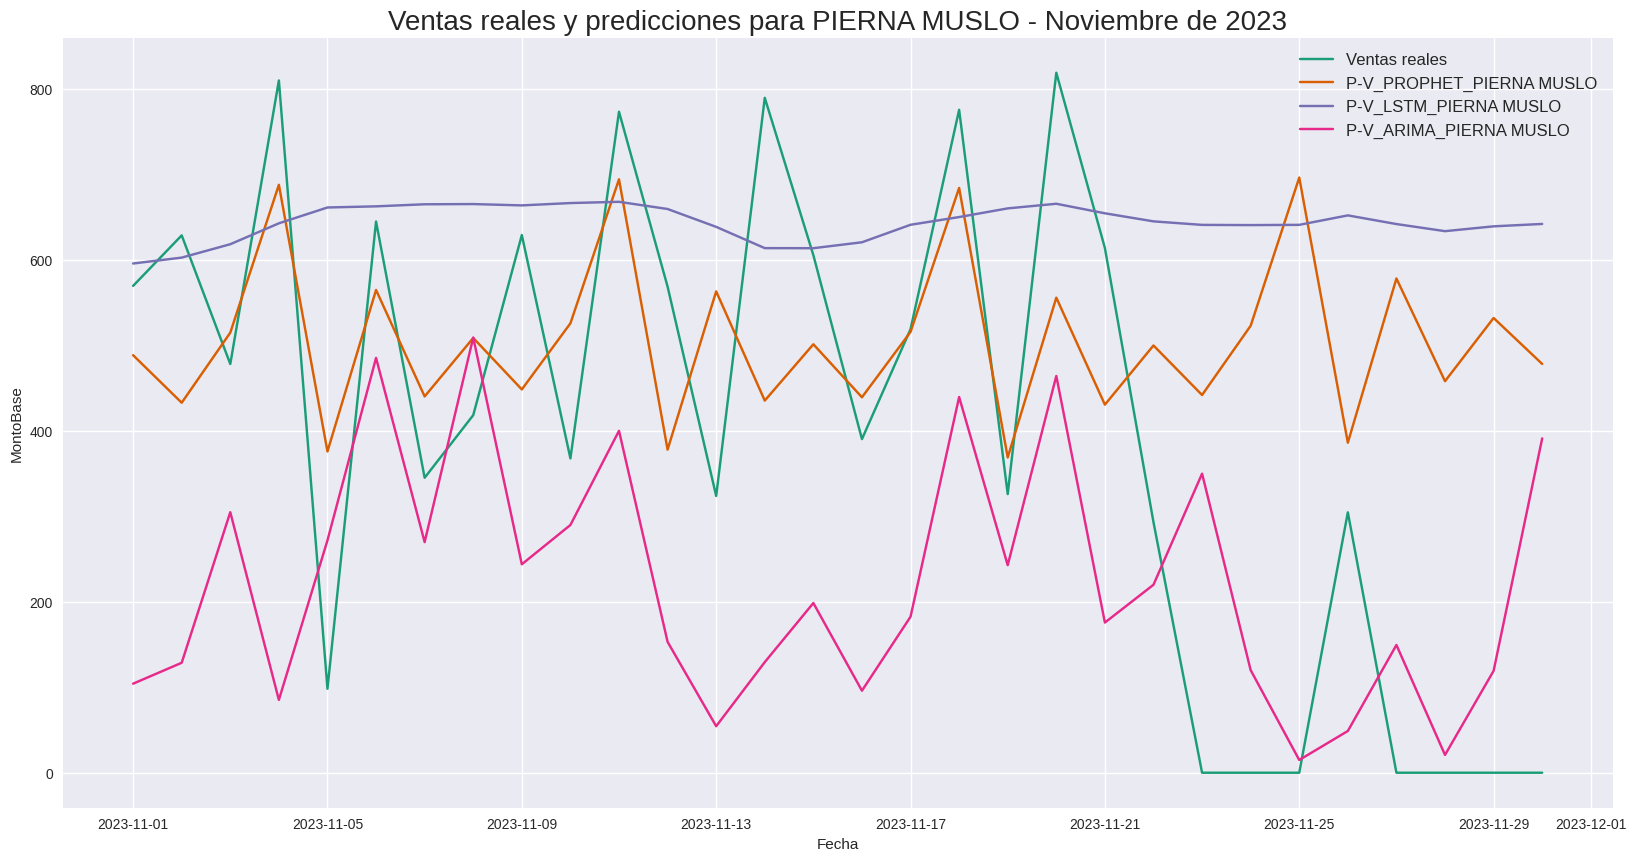

In [53]:
# Obtener la lista de productos
productos = list(dfs_noviembre_sumados.keys())

# Configurar el gráfico
plt.style.use('seaborn')
sns.set_palette("Dark2")
# Iterar sobre los productos
for product in productos:
    # Obtener los datos del producto actual
    product_data = dfs_noviembre_sumados[product]

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_data.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto, omitir el gráfico
        continue

    # Configurar el gráfico para el producto actual
    plt.figure(figsize=(20, 10))
    plt.plot(product_data.index, product_data['MontoBase'], label='Ventas reales')

    # Graficar todas las predicciones disponibles
    for pred in predicciones_disponibles:
        plt.plot(product_data.index, product_data[pred], label=pred)

    # Configurar etiquetas y leyenda
    plt.title(f'Ventas reales y predicciones para {product} - Noviembre de 2023', fontsize=20)
    plt.xlabel('Fecha')
    plt.ylabel('MontoBase')
    plt.legend(fontsize=12)
    plt.show()

In [54]:
# Iterar sobre los productos
for product, product_df in dfs_noviembre_sumados.items():
    print(f'Evaluación del producto: {product}')

    # Verificar si hay predicciones disponibles para el producto
    predicciones_disponibles = [col for col in product_df.columns if 'P-V_' in col]

    if not predicciones_disponibles:
        # No hay predicciones disponibles para el producto
        print(f"No hay predicciones para {product}.")
        continue

    # Calcular métricas de evaluación para cada predicción disponible
    for pred in predicciones_disponibles:
        # Extraer el nombre del modelo de la columna de predicciones
        nombre_modelo = pred.split('_')[1]

        y_real = product_df['MontoBase']
        y_pred = product_df[pred]

        print(f'Modelo: {nombre_modelo}')
        evaluacion_metrica(y_real, y_pred)

    print("\n\n")

Evaluación del producto: POLLO ESPECIAL
Modelo: PROPHET
Evaluation metric results:  
MSE is : 377498.3506497769
MAE is : 494.8538132851315
R2 is : -0.03936577451588308 %
------------------------------
MRSE is : 614.4089441485833
MAPE is : 69.37954756974636 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------


Modelo: LSTM
Evaluation metric results:  
MSE is : 594967.9288988865
MAE is : 566.0767019140626
R2 is : -0.6381245141010197 %
------------------------------
MRSE is : 771.3416421397761
MAPE is : 95.13629687444603 %
------------------------------
------------------------------
Días reales calculados: 29
Días omitidos: 1
Total de días: 30
------------------------------


Modelo: ARIMA
Evaluation metric results:  
MSE is : 2161471.99246438
MAE is : 1298.5011590928807
R2 is : -4.951178349985347 %
------------------------------
MRSE is : 1470.1945423869522
MAPE is : 175.284956961052

In [55]:
for product, product_df in dfs_noviembre_sumados.items():
    print(product_df)

                 NombreProducto  MontoBase  P-V_PROPHET_POLLO ESPECIAL  \
FechaMovimiento                                                          
2023-11-01       POLLO ESPECIAL  1999.7321                   1938.0934   
2023-11-02       POLLO ESPECIAL  1011.2892                   1740.8432   
2023-11-03       POLLO ESPECIAL  2343.7883                   1963.4582   
2023-11-04       POLLO ESPECIAL  1673.2089                   2315.8646   
2023-11-05       POLLO ESPECIAL  1181.9289                   1502.5276   
2023-11-06       POLLO ESPECIAL   863.7984                   1889.2897   
2023-11-07       POLLO ESPECIAL  1648.4580                   1762.6734   
2023-11-08       POLLO ESPECIAL  1434.6711                   1835.1293   
2023-11-09       POLLO ESPECIAL  1680.6493                   1619.1114   
2023-11-10       POLLO ESPECIAL  1767.7892                   1824.6313   
2023-11-11       POLLO ESPECIAL  1634.3693                   2162.0183   
2023-11-12       POLLO ESPECIAL   773.